# e-tivity 2 - Clustering and Manifold Learning

**Student Name:** Jason Coleman

**Student ID:** 9539719

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS, TSNE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, MinMaxScaler, RobustScaler, QuantileTransformer, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import joblib

In [2]:
# let's globally set the style of the plots
sns.set_palette("crest")
sns.set_style("whitegrid")
# Set option to display all columns
pd.set_option('display.max_columns', None)
current_palette = sns.color_palette()

colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple', 'red', 'yellow', 'gray', 'cyan', 'magenta'])

## Utility function to load dataframes
This was created to allow me to control the amount of data I read in; makes iterating easier if the data sets are smaller.

In [3]:
def load_bank_data():
    """
    Originally wrote this so I could sample the database
    """
    df = pd.read_csv('bank.csv')
    return df 

# Task 1: Data Preparation Pipeline

- Open a new Jupyter notebook and name it etivity2.ipynb. 
- In this notebook, create a data preparation pipeline that applies the same transformations that you applied as part of e-tivity 1. 
- It is OK to leave some of the transformations outside the pipeline but aim at including as many transformations as you can within the pipeline. 
- Follow the notebook Tutorial 2 - Clustering and Manifold Learning.ipynb as an example.

In this activity I tried to keep all of the operations in the pipeline. The reason for this was to make it easier to save the pipeline to disk for later use (also requires sharing any custom transformers). Thus the pipeline is self-contained and can be tested seperately. I found this very useful in my work. It is just good programming practice to write with the least moving parts and with a mindset that seperates concerns. 

## EDA Revisited (see etivity1 for more detail)
I will start by doing a quick review of the data set to help give context to the preprocessing stage.

In [4]:
df = load_bank_data()

In [5]:
df.describe()

age       balance          day     duration     campaign  \
count  1988.000000   2000.000000  2000.000000  2000.000000  2000.000000   
mean     41.753018   1413.663500    13.851500   292.020500     1.909500   
std      12.724358   3131.224213     9.712189   221.557295     1.378862   
min      18.000000   -980.000000     1.000000     7.000000     1.000000   
25%      32.000000    201.500000     5.000000   146.000000     1.000000   
50%      38.000000    551.000000    12.000000   236.000000     1.000000   
75%      50.000000   1644.500000    23.000000   379.000000     2.000000   
max      93.000000  81204.000000    31.000000  1823.000000    11.000000   

             pdays     previous  
count  2000.000000  2000.000000  
mean    167.896000     2.561500  
std     131.754126     3.400735  
min      -1.000000     0.000000  
25%      75.750000     1.000000  
50%     182.000000     2.000000  
75%     251.000000     3.000000  
max     854.000000    55.000000

<Figure size 2000x1500 with 0 Axes>

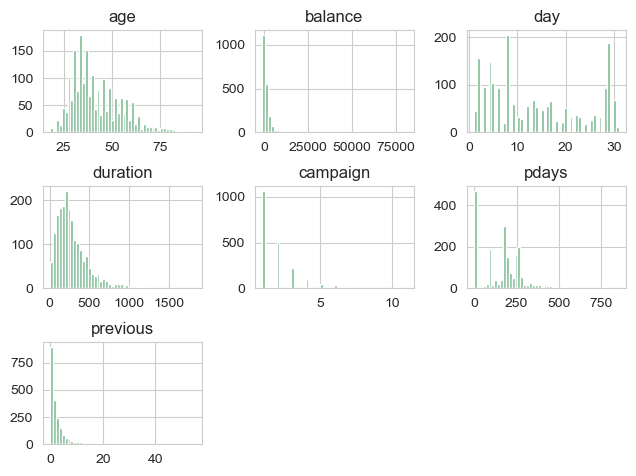

In [6]:
plt.figure(figsize=(20, 15)) 
ax_array = df.hist(bins=50)

# Rotate x-axis labels and adjust the layout
for ax_row in ax_array:
    for ax in ax_row:
        ax.set_xlabel(ax.get_xlabel(), rotation=45)
        ax.set_ylabel(ax.get_ylabel(), rotation=0)

plt.rcParams.update({'font.size': 8})

plt.tight_layout()
plt.show()

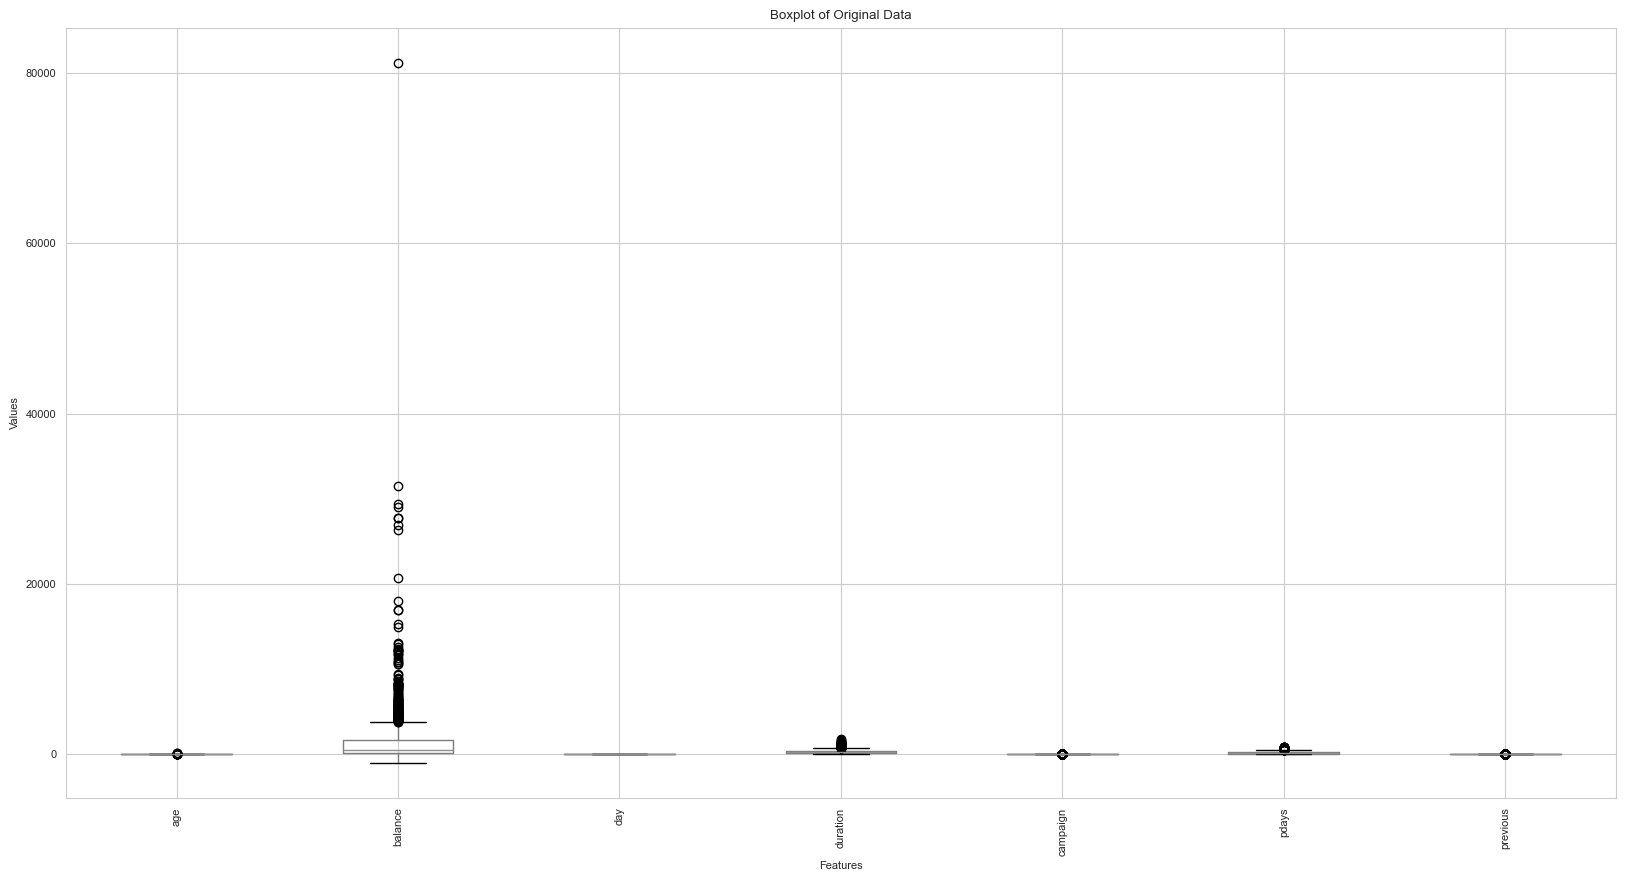

In [7]:
plt.figure(figsize=(20, 10)) 

# Create the boxplot
df.boxplot()

# Rotate the labels on the x-axis to prevent overlap
plt.xticks(rotation=90)

plt.title('Boxplot of Original Data')
plt.xlabel('Features')
plt.ylabel('Values')

plt.show()

Note the distrbution within these box plots. Some things to consider when building the preprocessing pipeline:

- Age has a slight right skew (close to normal)
- Balance is massively right skewed, with large outliers.
- Duration, campaign, pdays and previous are also right skewed.

Consider tackling outliers for Balance, at least.

## Building a Preprocessing Pipeline 
The following section combines all of the previous manual steps into a data preparation pipeline to perform:

- Numerical Imputation
- Numerical Standard Scaling
- Categorical Imputation
- Targeted Categorical Binary & OneHot Encoding
- Cyclical features for day and month

The processed data set is saved to CSV, reading for SVM (or whatever we choose to use). 

### Pipeline Utilities

#### Encoding day and month as cyclical features

To create cyclical features, I will transform both the day and month columns. Since the maximum value for days can vary from month to month, I will use a general approach that assumes a generic month length of 31 days for simplicity. For the month column, we'll convert the three-letter abbreviations to numerical values ranging from 1 (January) to 12 (December), then apply the cyclical transformation to both columns as part of the sci-kit pipeline.

I will need to create a custom transformer that I can use in the pipeline. I will do this first.Then I will pre-process the dataframe and save to a csv file, reading for use with an ML algorithm (or set of).

In [8]:
class CyclicalFeatureTransformer(BaseEstimator, TransformerMixin):
    def month_to_num(self, month):
        months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
        return months.index(month.lower()) + 1

    def create_cyclical_features(self, X, col):
        max_val = 12
        month_nums = X[col].apply(self.month_to_num)
        X[col + '_sin'] = np.sin(2 * np.pi * month_nums / max_val)
        X[col + '_cos'] = np.cos(2 * np.pi * month_nums / max_val)
        return X

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X = self.create_cyclical_features(X, 'month')
        X_transformed = X.drop(columns=['month'], axis=1)
        return X_transformed

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = ['month']  # 'month' maps to 'month_sin' and 'month_cos'
        return [input_features[0] + '_sin', input_features[0] + '_cos']

#### Test cyclic encoder, with min/maxxer scaler

In [9]:
# Define the pipeline
month_pipeline = Pipeline([
    ('cyclical', CyclicalFeatureTransformer()),
    ('scaler', MinMaxScaler())
])

import pandas as pd
df = pd.DataFrame({
    'month': ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
})

transformed_data = month_pipeline.fit_transform(df)

transformed_feature_names = month_pipeline.named_steps['cyclical'].get_feature_names_out(['month'])
print(transformed_feature_names)

transformed_data

['month_sin', 'month_cos']


array([[0.75     , 0.9330127],
       [0.9330127, 0.75     ],
       [1.       , 0.5      ],
       [0.9330127, 0.25     ],
       [0.75     , 0.0669873],
       [0.5      , 0.       ],
       [0.25     , 0.0669873],
       [0.0669873, 0.25     ],
       [0.       , 0.5      ],
       [0.0669873, 0.75     ],
       [0.25     , 0.9330127],
       [0.5      , 1.       ]])

#### Other Pipeline Utility Functions
I wrote the following to allow for a simpler pipeline. Additionally, these also allow me to retain the field names for each column afterwards, allowing me to more easily assess the differences, post-processing.

In [10]:
class ReplaceNonPositive(BaseEstimator, TransformerMixin):
    """
        Replace the values with NaN for later imputation
    """
    def __init__(self):
        self.feature_names = None

    def fit(self, X, y=None):
        if hasattr(X, 'columns'):
            self.feature_names = X.columns.tolist()
        return self

    def transform(self, X):
        X = X.copy()
        X[X <= 0] = np.nan
        return X

    def get_feature_names_out(self, input_features=None):
        if input_features is not None:
            return input_features
        else:
            raise ValueError("Input features must be provided to use get_feature_names_out method.")

class LogTransform(BaseEstimator, TransformerMixin):
    """
        Perform and log transform on the data
    """
    def __init__(self):
        self.feature_names = None

    def fit(self, X, y=None):
        if hasattr(X, 'columns'):
            self.feature_names = X.columns.tolist()
        return self

    def transform(self, X):
        X = X.copy()
        X_transformed = np.log(X + abs(min(X)) + 1) #should handle negative numbers

        return X_transformed

    def get_feature_names_out(self, input_features=None):
        if input_features is not None:
            return input_features
        else:
            raise ValueError("Input features must be provided to use get_feature_names_out method.")

class PassThrough(BaseEstimator, TransformerMixin):
    """
        Just a simple passthru class. May not need this. 
    """
    def __init__(self):
        self.feature_names = None

    def fit(self, X, y=None):
        if hasattr(X, 'columns'):
            self.feature_names = X.columns.tolist()
        return self

    def transform(self, X):
        X = X.copy()
        return X

    def get_feature_names_out(self, input_features=None):
        if input_features is not None:
            return input_features
        else:
            raise ValueError("Input features must be provided to use get_feature_names_out method.")

class OutlierRemover(BaseEstimator, TransformerMixin):
    """
    Remove outliers using the default 3 std. dev.
    """
    def __init__(self, n_std=3):
        self.n_std = n_std
        
    def fit(self, X, y=None):
        # Calculate the mean and std of the array
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)
        return self
    
    def transform(self, X, y=None):
        # Remove outliers - I may not want to do this for all columns
        conditions = np.abs((X - self.mean_) / self.std_) < self.n_std

        #mark the outlier rows
        is_outlier = np.logical_not(np.prod(conditions, axis=1))
        
        # Return only non-outlier rows
        return X[~is_outlier]

    def get_feature_names_out(self, input_features=None):
        # If no input_features provided, infer based on the expected output feature names
        if input_features is None:
            return ['month_sin', 'month_cos']  # default names for the transformed features
        else:
            # Optionally, create more specific feature names based on input_features
            new_features = []
            for feature in input_features:
                new_features.append(feature + '_sin')
                new_features.append(feature + '_cos')
            return new_features

    
class OutlierClipper(BaseEstimator, TransformerMixin):
    """
    Clip outlier values to a max of n_std dev. 
    Works if the distribution is normal to begin with.
    This is different to removal. We retain the other field
    data but clip to a max of n std dev.
    """
    def __init__(self, n_std=3):
        self.n_std = n_std
    
    def fit(self, X, y=None):
        # Calculate the mean and std of the array
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)
        return self
    
    def transform(self, X, y=None):
        # Clip outliers
        X_clipped = np.clip(X, self.mean_ - self.n_std * self.std_, self.mean_ + self.n_std * self.std_)
        return X_clipped

    def get_feature_names_out(self, input_features=None):
        if input_features is not None:
            return input_features
        else:
            raise ValueError("Input features must be provided to use get_feature_names_out method.")

class OutlierClipperIQR(BaseEstimator, TransformerMixin):
    """
    Clip outliers based on IQR tests, using a default scale of 1.5.
    From e-tivity1.
    """
    def __init__(self, lower_quantile=0.25, upper_quantile=0.75, iqr_scale=1.5):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.iqr_scale = iqr_scale
    
    def fit(self, X, y=None):
        # Compute the IQR
        Q1 = np.percentile(X, self.lower_quantile * 100, axis=0)
        Q3 = np.percentile(X, self.upper_quantile * 100, axis=0)
        self.iqr_ = Q3 - Q1
        
        # Compute the bounds for clipping
        self.lower_bound_ = Q1 - self.iqr_scale * self.iqr_
        self.upper_bound_ = Q3 + self.iqr_scale * self.iqr_
        return self
    
    def transform(self, X, y=None):
        # Clip the outliers to the boundary
        X_clipped = np.clip(X, self.lower_bound_, self.upper_bound_)
        return X_clipped

    def get_feature_names_out(self, input_features=None):
        # For compatibility with sklearn pipeline
        if input_features is not None:
            return input_features
        else:
            raise ValueError("Input features must be provided to use get_feature_names_out method.")

class OutcomeImputer(BaseEstimator, TransformerMixin):
    """
    Modifying the 'poutcome' column based on the 
    values in the 'pdays' column. Specifically, 
    it's setting the value of 'poutcome' to 'other' 
    for all rows where 'pdays' is -1.
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        #set poutcome to 'other' if pdays is -1, drop pdays column
        X_t = X.copy()
        X_t.loc[X_t['pdays'] == -1, 'poutcome'] = 'other'
        X_t.drop(columns=['pdays'], inplace=True)
             
        return X_t
        
    def get_feature_names_out(self, input_features=None):
        return pd.Index(['poutcome'])

#### Categorical kNN Imputation
The following code was used used based on feedback for etivity1. The original code can be found here: https://gist.github.com/YohanObadia/b310793cd22a4427faaadd9c381a5850. 

I have adapted it to fit into the pipeline as a custom transformer that retained the original column names. 

In [11]:
import numbers
from scipy.spatial.distance import cdist
from scipy.stats import hmean

def weighted_hamming(data):
    """ Compute weighted hamming distance on categorical variables. For one variable, it is equal to 1 if
        the values between point A and point B are different, else it is equal the relative frequency of the
        distribution of the value across the variable. For multiple variables, the harmonic mean is computed
        up to a constant factor.
        @params:
            - data = a pandas data frame of categorical variables
        @returns:
            - distance_matrix = a distance matrix with pairwise distance for all attributes
    """
    categories_dist = []
    
    for category in data:
        X = pd.get_dummies(data[category])
        X_mean = X * X.mean()
        X_dot = X_mean.dot(X.transpose())
        X_np = np.asarray(X_dot.replace(0,1,inplace=False))
        categories_dist.append(X_np)
    categories_dist = np.array(categories_dist)
    distances = hmean(categories_dist, axis=0)
    return distances

def distance_matrix(data, numeric_distance = "euclidean", categorical_distance = "jaccard"):
    """ Compute the pairwise distance attribute by attribute in order to account for different variables type:
        - Continuous
        - Categorical
        For ordinal values, provide a numerical representation taking the order into account.
        Categorical variables are transformed into a set of binary ones.
        If both continuous and categorical distance are provided, a Gower-like distance is computed and the numeric
        variables are all normalized in the process.
        If there are missing values, the mean is computed for numerical attributes and the mode for categorical ones.
        
        Note: If weighted-hamming distance is chosen, the computation time increases a lot since it is not coded in C 
        like other distance metrics provided by scipy.
        @params:
            - data                  = pandas dataframe to compute distances on.
            - numeric_distances     = the metric to apply to continuous attributes.
                                      "euclidean" and "cityblock" available.
                                      Default = "euclidean"
            - categorical_distances = the metric to apply to binary attributes.
                                      "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                      available. Default = "jaccard"
        @returns:
            - the distance matrix
    """
    possible_continuous_distances = ["euclidean", "cityblock"]
    possible_binary_distances = ["euclidean", "jaccard", "hamming", "weighted-hamming"]
    number_of_variables = data.shape[1]
    number_of_observations = data.shape[0]

    # Get the type of each attribute (Numeric or categorical)
    is_numeric = [all(isinstance(n, numbers.Number) for n in data.iloc[:, i]) for i, x in enumerate(data)]
    is_all_numeric = sum(is_numeric) == len(is_numeric)
    is_all_categorical = sum(is_numeric) == 0
    is_mixed_type = not is_all_categorical and not is_all_numeric

    # Check the content of the distances parameter
    if numeric_distance not in possible_continuous_distances:
        print("The continuous distance " + numeric_distance + " is not supported.")
        return None
    elif categorical_distance not in possible_binary_distances:
        print("The binary distance " + categorical_distance + " is not supported.")
        return None

    # Separate the data frame into categorical and numeric attributes and normalize numeric data
    if is_mixed_type:
        number_of_numeric_var = sum(is_numeric)
        number_of_categorical_var = number_of_variables - number_of_numeric_var
        data_numeric = data.iloc[:, is_numeric]
        data_numeric = (data_numeric - data_numeric.mean()) / (data_numeric.max() - data_numeric.min())
        data_categorical = data.iloc[:, [not x for x in is_numeric]]

    # Replace missing values with column mean for numeric values and mode for categorical ones. With the mode, it
    # triggers a warning: "SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame"
    # but the value are properly replaced
    if is_mixed_type:
        data_numeric.fillna(data_numeric.mean(), inplace=True)
        for x in data_categorical:
            data_categorical[x].fillna(data_categorical[x].mode()[0], inplace=True)
    elif is_all_numeric:
        data.fillna(data.mean(), inplace=True)
    else:
        for x in data:
            data[x].fillna(data[x].mode()[0], inplace=True)

    # "Dummifies" categorical variables in place
    if not is_all_numeric and not (categorical_distance == 'hamming' or categorical_distance == 'weighted-hamming'):
        if is_mixed_type:
            data_categorical = pd.get_dummies(data_categorical)
        else:
            data = pd.get_dummies(data)
    elif not is_all_numeric and categorical_distance == 'hamming':
        if is_mixed_type:
            data_categorical = pd.DataFrame([pd.factorize(data_categorical[x])[0] for x in data_categorical]).transpose()
        else:
            data = pd.DataFrame([pd.factorize(data[x])[0] for x in data]).transpose()

    if is_all_numeric:
        result_matrix = cdist(data, data, metric=numeric_distance)
    elif is_all_categorical:
        if categorical_distance == "weighted-hamming":
            result_matrix = weighted_hamming(data)
        else:
            result_matrix = cdist(data, data, metric=categorical_distance)
    else:
        result_numeric = cdist(data_numeric, data_numeric, metric=numeric_distance)
        if categorical_distance == "weighted-hamming":
            result_categorical = weighted_hamming(data_categorical)
        else:
            result_categorical = cdist(data_categorical, data_categorical, metric=categorical_distance)
        result_matrix = np.array([[1.0*(result_numeric[i, j] * number_of_numeric_var + result_categorical[i, j] *
                               number_of_categorical_var) / number_of_variables for j in range(number_of_observations)] for i in range(number_of_observations)])

    # Fill the diagonal with NaN values
    np.fill_diagonal(result_matrix, np.nan)

    return pd.DataFrame(result_matrix)

def knn_impute(target, attributes, k_neighbors, aggregation_method="mean", numeric_distance="euclidean",
               categorical_distance="jaccard", missing_neighbors_threshold = 0.5):
    """ Replace the missing values within the target variable based on its k nearest neighbors identified with the
        attributes variables. If more than 50% of its neighbors are also missing values, the value is not modified and
        remains missing. If there is a problem in the parameters provided, returns None.
        If to many neighbors also have missing values, leave the missing value of interest unchanged.
        @params:
            - target                        = a vector of n values with missing values that you want to impute. The length has
                                              to be at least n = 3.
            - attributes                    = a data frame of attributes with n rows to match the target variable
            - k_neighbors                   = the number of neighbors to look at to impute the missing values. It has to be a
                                              value between 1 and n.
            - aggregation_method            = how to aggregate the values from the nearest neighbors (mean, median, mode)
                                              Default = "mean"
            - numeric_distances             = the metric to apply to continuous attributes.
                                              "euclidean" and "cityblock" available.
                                              Default = "euclidean"
            - categorical_distances         = the metric to apply to binary attributes.
                                              "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                              available. Default = "jaccard"
            - missing_neighbors_threshold   = minimum of neighbors among the k ones that are not also missing to infer
                                              the correct value. Default = 0.5
        @returns:
            target_completed        = the vector of target values with missing value replaced. If there is a problem
                                      in the parameters, return None
    """

    # Get useful variables
    possible_aggregation_method = ["mean", "median", "mode"]
    number_observations = len(target)
    is_target_numeric = all(isinstance(n, numbers.Number) for n in target)

    # Check for possible errors
    if number_observations < 3:
        print("Not enough observations.")
        return None
    if attributes.shape[0] != number_observations:
        print("The number of observations in the attributes variable is not matching the target variable length.")
        return None
    if k_neighbors > number_observations or k_neighbors < 1:
        print("The range of the number of neighbors is incorrect.")
        return None
    if aggregation_method not in possible_aggregation_method:
        print("The aggregation method is incorrect.")
        return None
    if not is_target_numeric and aggregation_method != "mode":
        print("The only method allowed for categorical target variable is the mode.")
        return None

    # Make sure the data are in the right format
    target = pd.DataFrame(target)
    attributes = pd.DataFrame(attributes)

    # Get the distance matrix and check whether no error was triggered when computing it
    distances = distance_matrix(attributes, numeric_distance, categorical_distance)
    if distances is None:
        return None

    # Get the closest points and compute the correct aggregation method
    for i, value in enumerate(target.iloc[:, 0]):
        if pd.isnull(value):
            order = distances.iloc[i,:].values.argsort()[:k_neighbors]
            closest_to_target = target.iloc[order, :]
            missing_neighbors = [x for x  in closest_to_target.isnull().iloc[:, 0]]
            # Compute the right aggregation method if at least more than 50% of the closest neighbors are not missing
            if sum(missing_neighbors) >= missing_neighbors_threshold * k_neighbors:
                continue
            elif aggregation_method == "mean":
                target.iloc[i] = np.ma.mean(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            elif aggregation_method == "median":
                target.iloc[i] = np.ma.median(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            else:
                # My implementation as provided code was not working for this scenario
                closest_to_target_str = closest_to_target.astype("str")
                values, values_counts = np.unique(closest_to_target_str, return_counts=True)
                filtered_values_counts = [(value, count) for value, count in zip(values, values_counts) if str(value).lower() != "nan"]
                values_filtered, values_counts_filtered = zip(*filtered_values_counts)
                mode_index = np.argmax(values_counts_filtered)
                target.iloc[i] = values_filtered[mode_index]
    
    return target

class KNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self, column, k_neighbors=3, aggregation_method='mode'):
        """
        This is the new code. Initialises the transformer 
        with specified settings for KNN imputation.

        Parameters:
        - column : str
            The column name to which KNN imputation should be applied.
        - k_neighbors : int, default=3
            The number of neighbors to consider for imputing.
        - aggregation_method : str, default='mode'
            The aggregation method to use for combining neighbor values.
        """
        self.column = column
        self.k_neighbors = k_neighbors
        self.aggregation_method = aggregation_method

    def fit(self, X, y=None):
        # No fitting needed for this imputer, return self to allow chaining.
        return self

    def transform(self, X):
        """
        Apply KNN imputation to the specified column in the dataframe.

        Parameters:
        - X : DataFrame
            The original dataframe from which to impute values.
        
        Returns:
        - X : DataFrame
            The dataframe with the specified column imputed.
        """
        if self.column in X.columns:
            # Make a copy to avoid changing original data
            data_frame = X.copy()
            
            # Extract the target column
            education_feature_column = data_frame[self.column]
            
            # Drop target column from dataframe
            data_frame_without_education_column = data_frame.drop(self.column, axis=1)
            
            # Impute the education column using the external KNN impute function
            # Assuming knn_impute is already defined and imported
            imputed_education_feature = knn_impute(
                education_feature_column,
                data_frame_without_education_column,
                self.k_neighbors,
                self.aggregation_method
            )
            
            # Replace the original column with imputed data
            data_frame[self.column] = imputed_education_feature.astype(str)
            
            return data_frame
        else:
            raise ValueError(f"The column {self.column} is not in the dataframe")
        
    def get_feature_names_out(self, input_features=None):
        # For compatibility with sklearn pipeline
        if input_features is not None:
            return input_features
        else:
            raise ValueError("Input features must be provided to use get_feature_names_out method.")

### Loading the csv into the data frame

Now we create and run the pre-processing pipeline. The output it a csv file called `bank_processed_pipeline.csv`.

In [12]:
df = load_bank_data()

In [13]:
df.head()

age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  \
0  cellular    1   apr       957         2    131         2  failure   
1  cellular    1   apr       233         2    133         1  failure   
2  cellular    1   apr       126         2    239         1  failure   
3  cellular    1   apr       274         1    238         2  failure   
4  cellular    1   apr       479         1    307         1  failure   

  subscribed  
0         no  
1         no  
2         no  
3         no  
4         no

In [14]:
df.describe()

age       balance          day     duration     campaign  \
count  1988.000000   2000.000000  2000.000000  2000.000000  2000.000000   
mean     41.753018   1413.663500    13.851500   292.020500     1.909500   
std      12.724358   3131.224213     9.712189   221.557295     1.378862   
min      18.000000   -980.000000     1.000000     7.000000     1.000000   
25%      32.000000    201.500000     5.000000   146.000000     1.000000   
50%      38.000000    551.000000    12.000000   236.000000     1.000000   
75%      50.000000   1644.500000    23.000000   379.000000     2.000000   
max      93.000000  81204.000000    31.000000  1823.000000    11.000000   

             pdays     previous  
count  2000.000000  2000.000000  
mean    167.896000     2.561500  
std     131.754126     3.400735  
min      -1.000000     0.000000  
25%      75.750000     1.000000  
50%     182.000000     2.000000  
75%     251.000000     3.000000  
max     854.000000    55.000000

### Building the Pipelines

As I am learning, I will target every input specifically. This should make it easier ro reason about. Inspiration for this came from [here](https://gitlab.com/ruilima/cs5062/-/blob/main/etivity2/etivity2.ipynb) by Rui Lima. 

Create some generic pipelines for common processing. I know I need to handle:

* missing values
* skewed data, in some cases
* Outliers
* non-normal distributions (in some cases)
* scaling to a common range (as both kMeans and DBSCAN are distance based metrics and any non-scaled data may *throw-off* the outcomes). 

In [15]:
generic_categorical_unknown_impute_1hot_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

generic_numerical_median_impute_minmaxscaler_pipeline_highly_rightskewed = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('outlier_clipper_iqr', OutlierClipperIQR()),
    ('power_transform', PowerTransformer(method='yeo-johnson')),
    ('scaler', MinMaxScaler())
])

generic_numerical_median_impute_minmax_scaler_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
]) # I am purposely not removing outliers here as I want to see if they add value

Start defining the preprocessing pipeline per field

In [16]:
age_pipeline        = generic_numerical_median_impute_minmax_scaler_pipeline
job_pipeline        = generic_categorical_unknown_impute_1hot_pipeline
marital_pipeline    = generic_categorical_unknown_impute_1hot_pipeline  
education_pipeline  = Pipeline([
    ("knn-imputer", KNNImputer('education', 3, 'mode')), 
    ("onehot", OneHotEncoder(handle_unknown='ignore', drop=None))  
]) 
default_pipeline    = generic_categorical_unknown_impute_1hot_pipeline 
balance_pipeline = generic_numerical_median_impute_minmaxscaler_pipeline_highly_rightskewed
housing_pipeline    = generic_categorical_unknown_impute_1hot_pipeline  
loan_pipeline       = generic_categorical_unknown_impute_1hot_pipeline  
contact_pipeline    = generic_categorical_unknown_impute_1hot_pipeline  
day_pipeline = generic_numerical_median_impute_minmax_scaler_pipeline
month_pipeline = Pipeline([ 
    ('cyclical', CyclicalFeatureTransformer()),
    ('scaler', MinMaxScaler())
])
duration_pipeline   = generic_numerical_median_impute_minmaxscaler_pipeline_highly_rightskewed
campaign_pipeline = generic_numerical_median_impute_minmax_scaler_pipeline
pdays_pipeline = generic_numerical_median_impute_minmaxscaler_pipeline_highly_rightskewed
previous_pipeline = generic_numerical_median_impute_minmax_scaler_pipeline
poutcome_pipeline = Pipeline([
    ('imputer', OutcomeImputer()),
    ('onehot', OneHotEncoder(handle_unknown='ignore',drop=None))
])

- I have elected to have one pipeline per column. 
- Initially, I had "clumped" several columns into fewer pipelines but this made the preprocessor harder to reason about (the data is heterogenoues and I ran into issues especially as I tweaked the subpipelines - e.g. changed imputer strategy, numerical skew processing etc...). 
- At least here, I can see exactly how each column is processed (at a glance). 
- Obviously, this could be collapsed into a simpler pipeline once I better understand the needs of the system. 

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('age_pipeline', age_pipeline, ['age']),
        ('job_pipeline', job_pipeline, ['job']),
        ('marital_pipeline', marital_pipeline, ['marital']),
        ('education_pipeline', education_pipeline, ['education']),
        ('default_pipeline', default_pipeline, ['default']),
        ('balance_pipeline', balance_pipeline, ['balance']),
        ('duration_pipeline', duration_pipeline, ['duration']),
        ('housing_pipeline', housing_pipeline, ['housing']),
        ('loan_pipeline', loan_pipeline, ['loan']),
        ('contact_pipeline', contact_pipeline, ['contact']),
        ('month_pipeline', month_pipeline, ['month']),
        ('day_pipeline', day_pipeline, ['day']),
        ('campaign_pipeline', campaign_pipeline, ['campaign']),
        ('pdays_pipeline', pdays_pipeline, ['pdays']),
        ('previous_pipeline', previous_pipeline, ['previous']),
        ('poutcome_pipeline', poutcome_pipeline, ['poutcome', 'pdays'])
    ],
    remainder = 'drop' # subscribed - this is the target variable and will likely skew any clustering
)

Apply preprocessing

In [18]:
preprocessor.fit(df)

ColumnTransformer(transformers=[('age_pipeline',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['age']),
                                ('job_pipeline',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['job']),
                                ('marital_pipeline',
                                 Pipeline(s...
                                                  OutlierClipperIQR()),
                                                 ('power_transform',
                                                  PowerTransformer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['pdays']),
                                ('previous_pipeline',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['previous']),
                                ('poutcome_pipeline',
                                 Pipeline(steps=[('imputer', OutcomeImputer()),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['poutcome', 'pdays'])])

### Retaining Column names Post-Preprocessing
The following section allows me to retain the columns names, post-transform. This makes it easier to see the effect of the transformations, per column.

In [19]:
# Getting feature names from ColumnTransformer
cleaned_feature_names = preprocessor.get_feature_names_out()
cleaned_feature_names = [name.split('__', 1)[-1] for name in preprocessor.get_feature_names_out()]

# Transform the entire dataset
transformed_data = preprocessor.transform(df)

# Convert the transformed data back into a DataFrame and visually confirm the results of processing
df_preprocessed = pd.DataFrame(transformed_data, columns=cleaned_feature_names)
df_preprocessed.info()
df_preprocessed.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  2000 non-null   float64
 1   job_blue-collar      2000 non-null   float64
 2   job_entrepreneur     2000 non-null   float64
 3   job_housemaid        2000 non-null   float64
 4   job_management       2000 non-null   float64
 5   job_retired          2000 non-null   float64
 6   job_self-employed    2000 non-null   float64
 7   job_services         2000 non-null   float64
 8   job_student          2000 non-null   float64
 9   job_technician       2000 non-null   float64
 10  job_unemployed       2000 non-null   float64
 11  job_unknown          2000 non-null   float64
 12  marital_married      2000 non-null   float64
 13  marital_single       2000 non-null   float64
 14  education_primary    2000 non-null   float64
 15  education_secondary  2000 non-null   f

age  job_blue-collar  job_entrepreneur  job_housemaid  \
count  2000.000000      2000.000000        2000.00000    2000.000000   
mean      0.316407         0.149000           0.02250       0.017500   
std       0.169192         0.356178           0.14834       0.131158   
min       0.000000         0.000000           0.00000       0.000000   
25%       0.186667         0.000000           0.00000       0.000000   
50%       0.266667         0.000000           0.00000       0.000000   
75%       0.426667         0.000000           0.00000       0.000000   
max       1.000000         1.000000           1.00000       1.000000   

       job_management  job_retired  job_self-employed  job_services  \
count     2000.000000  2000.000000        2000.000000   2000.000000   
mean         0.230500     0.081000           0.032000      0.082500   
std          0.421258     0.272903           0.176044      0.275194   
min          0.000000     0.000000           0.000000      0.000000   
25%          0.000000     0.000000           0.000000      0.000000   
50%          0.000000     0.000000           0.000000      0.000000   
75%          0.000000     0.000000           0.000000      0.000000   
max          1.000000     1.000000           1.000000      1.000000   

       job_student  job_technician  job_unemployed  job_unknown  \
count   2000.00000     2000.000000     2000.000000  2000.000000   
mean       0.04800        0.174000        0.034500     0.005000   
std        0.21382        0.379204        0.182555     0.070551   
min        0.00000        0.000000        0.000000     0.000000   
25%        0.00000        0.000000        0.000000     0.000000   
50%        0.00000        0.000000        0.000000     0.000000   
75%        0.00000        0.000000        0.000000     0.000000   
max        1.00000        1.000000        1.000000     1.000000   

       marital_married  marital_single  education_primary  \
count      2000.000000     2000.000000        2000.000000   
mean          0.555500        0.337000           0.108500   
std           0.497034        0.472803           0.311089   
min           0.000000        0.000000           0.000000   
25%           0.000000        0.000000           0.000000   
50%           1.000000        0.000000           0.000000   
75%           1.000000        1.000000           0.000000   
max           1.000000        1.000000           1.000000   

       education_secondary  education_tertiary  default_yes      balance  \
count          2000.000000         2000.000000  2000.000000  2000.000000   
mean              0.549500            0.342000     0.007500     0.727315   
std               0.497668            0.474498     0.086299     0.131310   
min               0.000000            0.000000     0.000000     0.000000   
25%               0.000000            0.000000     0.000000     0.642650   
50%               1.000000            0.000000     0.000000     0.685159   
75%               1.000000            1.000000     0.000000     0.800020   
max               1.000000            1.000000     1.000000     1.000000   

          duration  housing_yes     loan_yes  contact_telephone  \
count  2000.000000  2000.000000  2000.000000        2000.000000   
mean      0.603875     0.481500     0.125000           0.073000   
std       0.204969     0.499783     0.330802           0.260202   
min       0.000000     0.000000     0.000000           0.000000   
25%       0.466742     0.000000     0.000000           0.000000   
50%       0.596941     0.000000     0.000000           0.000000   
75%       0.747891     1.000000     0.000000           0.000000   
max       1.000000     1.000000     1.000000           1.000000   

       contact_unknown    month_sin    month_cos          day     campaign  \
count      2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean          0.095500     0.609147     0.463263     0.428383     0.090950   
std           0.293978     0.342950     0.345313 

### Review the histograms.
Here I take a quick look at the data to ensure the pipeline is doing what I think it is doing.

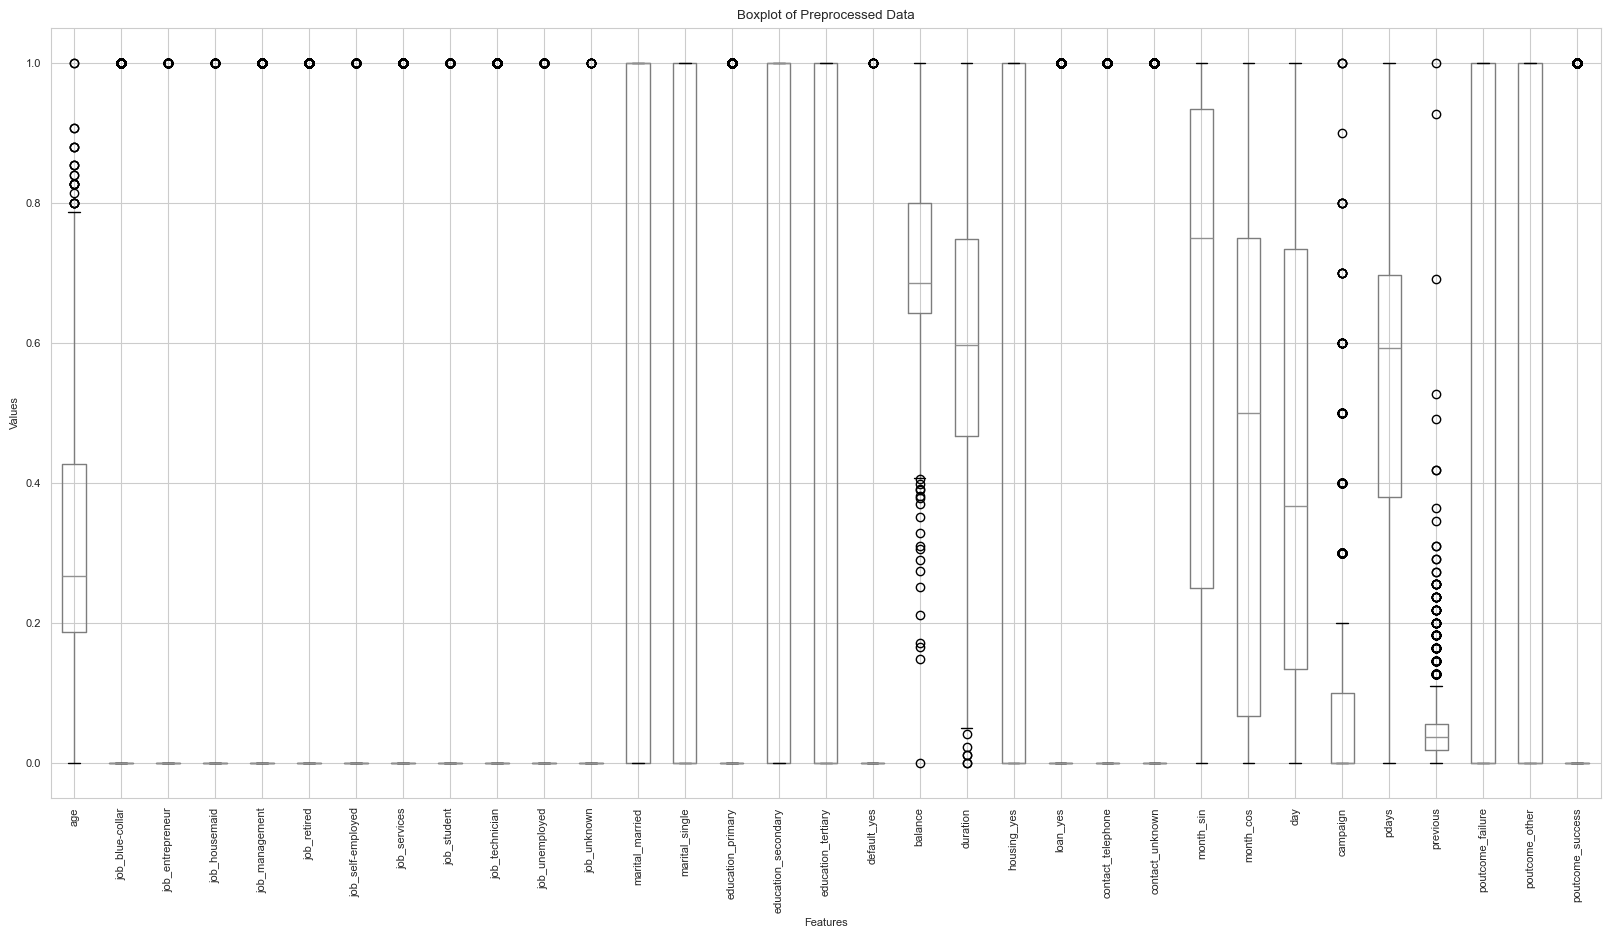

In [20]:
plt.figure(figsize=(20, 10)) 

# Create the boxplot
df_preprocessed.boxplot()

# Rotate the labels on the x-axis to prevent overlap
plt.xticks(rotation=90)

plt.title('Boxplot of Preprocessed Data')
plt.xlabel('Features')
plt.ylabel('Values')

plt.show()

All columns appear in the same range. 

### A note on outliers
I have purposely kept some outliers so the data is not too sterile. With more time I would like to evaluate the impact of removing these.

I decided to clip balance outliers using the IQR $\times$ 1.5  method but opted to keep the outliers on age, campaign, pdays and previous. If I clip all outliers in all right skewed columns it renders downstream plots for kMeans (and dimension reduction with t-SNE and MDS) meaningless; i.e. the cluster distribution become nonsensical. So, for now, I only tackle highly skewed data with very large outliers.

In [21]:
df_preprocessed.head(5)

age  job_blue-collar  job_entrepreneur  job_housemaid  job_management  \
0  0.186667              0.0               0.0            0.0             0.0   
1  0.280000              0.0               0.0            0.0             0.0   
2  0.546667              0.0               0.0            0.0             0.0   
3  0.386667              1.0               0.0            0.0             0.0   
4  0.480000              0.0               0.0            0.0             0.0   

   job_retired  job_self-employed  job_services  job_student  job_technician  \
0          0.0                0.0           0.0          0.0             1.0   
1          0.0                0.0           0.0          0.0             1.0   
2          1.0                0.0           0.0          0.0             0.0   
3          0.0                0.0           0.0          0.0             0.0   
4          1.0                0.0           0.0          0.0             0.0   

   job_unemployed  job_unknown  marital_married  marital_single  \
0             0.0          0.0              0.0             1.0   
1             0.0          0.0              0.0             0.0   
2             0.0          0.0              1.0             0.0   
3             0.0          0.0              1.0             0.0   
4             0.0          0.0              1.0             0.0   

   education_primary  education_secondary  education_tertiary  default_yes  \
0                0.0                  0.0                 1.0          0.0   
1                0.0                  1.0                 0.0          0.0   
2                0.0                  1.0                 0.0          0.0   
3                0.0                  1.0                 0.0          0.0   
4                0.0                  1.0                 0.0          0.0   

    balance  duration  housing_yes  loan_yes  contact_telephone  \
0  0.666511  1.000000          1.0       0.0                0.0   
1  0.700626  0.593190          1.0       1.0                0.0   
2  0.738089  0.430877          1.0       1.0                0.0   
3  0.667232  0.641933          1.0       1.0                0.0   
4  0.734822  0.831919          1.0       0.0                0.0   

   contact_unknown  month_sin  month_cos  day  campaign     pdays  previous  \
0              0.0   0.933013       0.25  0.0       0.1  0.500981  0.036364   
1              0.0   0.933013       0.25  0.0       0.1  0.504859  0.018182   
2              0.0   0.933013       0.25  0.0       0.1  0.679716  0.018182   
3              0.0   0.933013       0.25  0.0       0.0  0.678275  0.036364   
4              0.0   0.933013       0.25  0.0       0.0  0.771411  0.018182   

   poutcome_failure  poutcome_other  poutcome_success  
0               1.0             0.0               0.0  
1               1.0             0.0               0.0  
2               1.0             0.0               0.0  
3               1.0             0.0               0.0  
4               1.0             0.0               0.0

Now save preprocessed dataframe to CSV

In [22]:
df_preprocessed.to_csv('bank_preprocessed_pipeline.csv', index=False)
print(f"Preprocessed data saved to: bank_preprocessed_pipeline.csv")

Preprocessed data saved to: bank_preprocessed_pipeline.csv


And save pipeline to pickle

In [23]:
joblib.dump(preprocessor, 'preprocessor_pipeline.pkl')

['preprocessor_pipeline.pkl']

Show the pipeline, visually...

In [24]:
from sklearn.svm import SVC
preprocessor_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor) 
])

preprocessor_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('age_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age']),
                                                 ('job_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['job']...
                                                                   OutlierClipperIQR()),
                                                                  ('power_transform',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['pdays']),
                                                 ('previous_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['previous']),
                                                 ('poutcome_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   OutcomeImputer()),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['poutcome', 'pdays'])]))])

Briefly, view the correlation matrix for the newly processed data. 

In [25]:
correlation_matrix = df_preprocessed.corr()

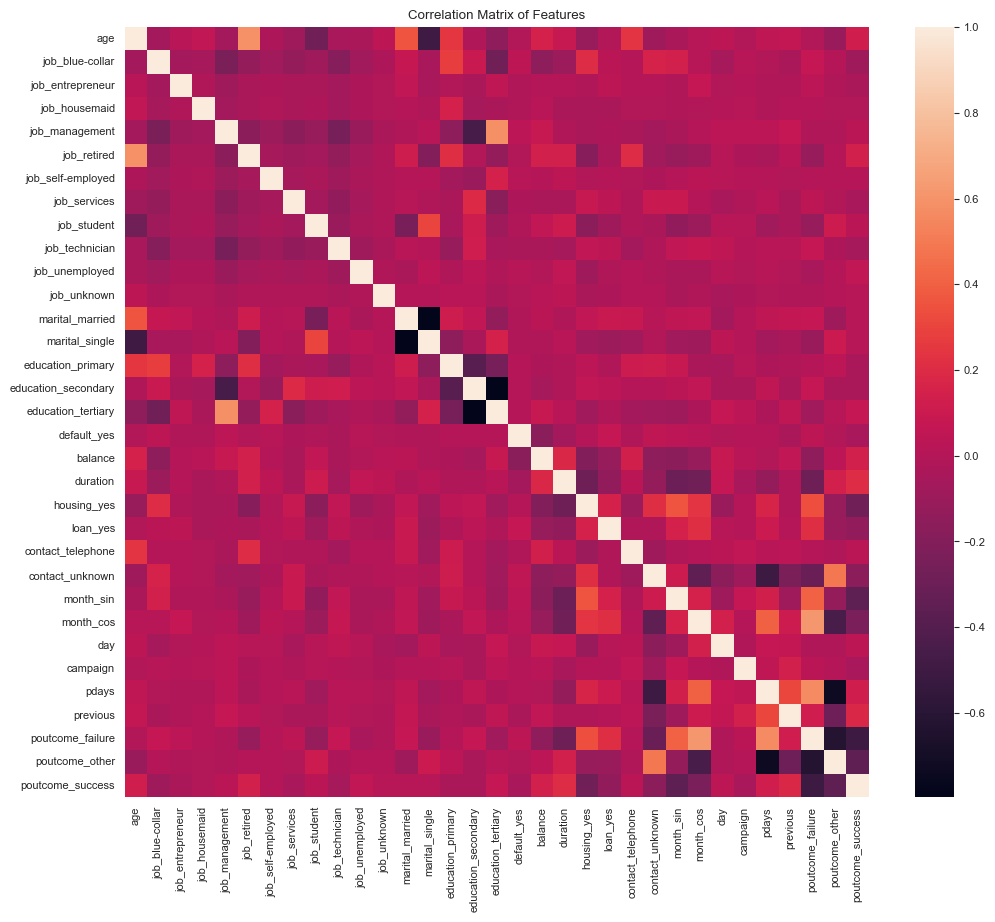

In [26]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cbar=True)
plt.title('Correlation Matrix of Features')
plt.show()

All columns are accounted for. We are reading for task 2.

# Task 2: k-Means
In your notebook e-tivity2.ipynb:

- Plot the sum of squared distances from the data points in the prepared bank dataset to the centers of the k-Means clusters for various values of k and use the Elbow method to pick the best value of k.
- Use the Silhouette Coefficient method to determine the best value of k as well.
- Use the best value(s) of k to cluster the prepared bank dataset with k-means. Aim at producing meaningful clustering.
- Use MDS and t-SNE for visualising the clusterings. 
- Write a short conclusion about the characteristics of the clusters (max 250 words in a markdown cell).

## Find the best value of k
I will start by trying to determine how many clusters I think this data set might have. We have a couple of approaches.

### The Elbow Method
The elbow method involves plotting the sum of squared distances of samples to their closest cluster center for various values of k. The "elbow" in the plot, where the rate of decrease sharply shifts, can often be a good choice for k.

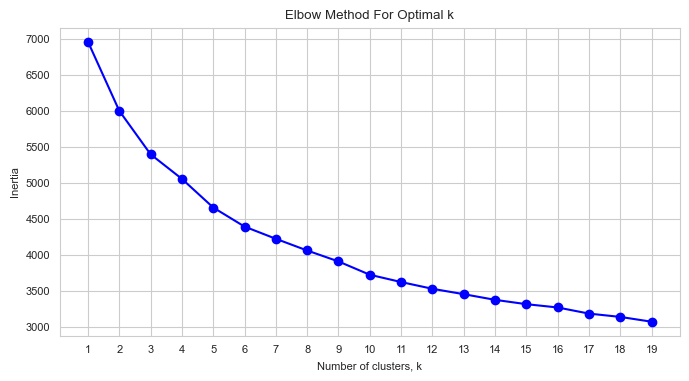

In [27]:
# Calculating inertia for a range of k
inertias = []
ks = range(1, 20)

plt.figure(figsize=(8,4))
for k in ks:
    model = KMeans(n_clusters=k, random_state=0)
    model.fit(df_preprocessed)
    plt.xticks(ks)
    inertias.append(model.inertia_)

plt.plot(ks, inertias, 'bo-')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

Clearly, if you squint your eyes, you could argue for $k = \{ 4...6\}$.

### Silhouette Coefficient method
The silhouette coefficient measures how similar an object is to its own cluster compared to other clusters; where a high value indicates that the objects are well matched to their own cluster and poorly matched to neighboring clusters.

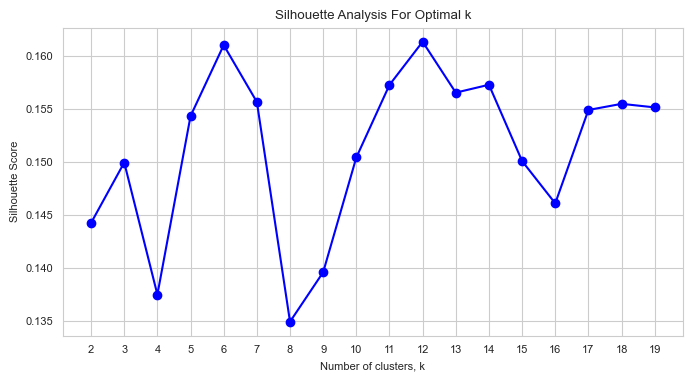

In [28]:
silhouette_scores = []
ks = range(2, 20)  # Silhouette score cannot be computed for k=1

plt.figure(figsize=(8,4))

for k in ks:
    model = KMeans(n_clusters=k, random_state=0)
    labels = model.fit_predict(df_preprocessed)
    score = silhouette_score(df_preprocessed, labels)
    silhouette_scores.append(score)  
    plt.xticks(ks)

plt.plot(ks, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters, k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.show()

Here I can pick 12, 6 or 3. Trial and error has led me to 6 as it gives the most cohesive clusters. The fact that 6 and 12 are sequential multiples of 3 is interesting and likely suggests some overall structure.

In [29]:
best_k_value = 6

## Clustering

### Scatterplot Function (to be used below for visualising a clustering)
This function `clustering_scatterplot()` was provided to us; it creates the 2D scatter plot of the clustered dataset.

In [30]:

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot

def clustering_scatterplot_kmeans(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

### Kmeans
The k-Means clustering algorithm has the number of clusters $k$ as an input parameter __n_clusters__. We construct a final pipeline for training a k-Means clustering model for a fixed value of __n_clusters__ $=6$. 

The final pipeline has the preprocessing pipeline as its first step followed by the scikit-learn KMeans algorithm as a second step.

Here I will use the pipeline to preprocess and then run kmeans on the resulting, preprocessed data. This is to demonstrate a cleaner workflow (and also avoid any mistakes due to accidentally overwriting a dataframe).

In [31]:
k = best_k_value # I picked this value earlier via the ellbow and silhouette analysis methods.

# Define the pipeline, with kmeans
pipe = Pipeline(steps=[
    ('preprocess', preprocessor_pipeline), 
    ('kMeans', KMeans(n_clusters=k, n_init=10, max_iter=300))
])

In [32]:
df = load_bank_data() #refresh df

Next, we fit the pipeline on the dataset to train a clustering model.

In [33]:
clustering_model = pipe.fit(df)
clustering_model

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('age_pipeline',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    MinMaxScaler())]),
                                                                   ['age']),
                                                                  ('job_pipeline',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(fill_value='unknown',
                                                                                                  strategy='constant')),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(drop='first',
                                                                                                  handl...
                                                                                   ('scaler',
                                                                                    MinMaxScaler())]),
                                                                   ['pdays']),
                                                                  ('previous_pipeline',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    MinMaxScaler())]),
                                                                   ['previous']),
                                                                  ('poutcome_pipeline',
                                                                   Pipeline(steps=[('imputer',
                                                                                    OutcomeImputer()),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['poutcome',
                                                                    'pdays'])]))])),
                ('kMeans', KMeans(n_clusters=6, n_init=10))])

Get the number of iterations. This tells me how quickly kMeans converges.

In [34]:
iterations = pipe.named_steps['kMeans'].n_iter_
print(f'Number of iterations before converging: {iterations}')

Number of iterations before converging: 7


### Cluster Review
Here I want to find the labels that were assigned and append them to the original, unprocessed dataframe. This is to allow me to reason about structure in the data and will involve a revisit of EDA as well as assessing how well clusters map the the subscribed variable. 

In [35]:
preprocessed_data = clustering_model['preprocess'].transform(df)
preprocessed_data

array([[0.18666667, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.28      , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.54666667, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.84      , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.37333333, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.29333333, 0.        , 1.        , ..., 0.        , 1.        ,
        0.        ]])

#### Add cluster id back to original datasets

Now I add the cluster member to the dataframe so I can inspect how it correlates with the target variable, subscribed.

In [36]:
df['cluster_kmeans'] = pd.Series(clustering_model['kMeans'].labels_, index=df.index)
df['cluster_kmeans'] = df['cluster_kmeans'].astype('int')

In [37]:
df.head(5)

age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  \
0  cellular    1   apr       957         2    131         2  failure   
1  cellular    1   apr       233         2    133         1  failure   
2  cellular    1   apr       126         2    239         1  failure   
3  cellular    1   apr       274         1    238         2  failure   
4  cellular    1   apr       479         1    307         1  failure   

  subscribed  cluster_kmeans  
0         no               4  
1         no               1  
2         no               1  
3         no               1  
4         no               1

In [38]:
df.tail(5)

age           job  marital  education default  balance housing loan  \
1995  20.0       student   single        NaN      no     2785      no   no   
1996  28.0        admin.   single  secondary      no      127      no   no   
1997  81.0       retired  married    primary      no     1154      no   no   
1998  46.0      services  married    primary      no     4343     yes   no   
1999  40.0  entrepreneur  married  secondary      no     6403      no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \
1995   cellular   16   sep       327         2     -1         0      NaN   
1996   cellular   16   sep      1334         2     -1         0      NaN   
1997  telephone   17   sep       231         1     -1         0      NaN   
1998        NaN   20   sep       185         1     -1         0      NaN   
1999   cellular   22   sep       208         2     -1         0      NaN   

     subscribed  cluster_kmeans  
1995        yes               5  
1996        yes               5  
1997        yes               0  
1998        yes               0  
1999        yes               5

I now have a cluster column and I'd like to see if values that correlate with cluster membership. I can do this with a contignecy table.

In [39]:
df['subscribed_numeric'] = df['subscribed'].apply(lambda x: 1 if x == 'yes' else 0)

cross_tab = pd.crosstab(df['subscribed_numeric'], df['cluster_kmeans'])
print(cross_tab)

cluster_kmeans        0    1    2    3    4    5
subscribed_numeric                              
0                   132  469   63    5  225  106
1                    49   90  321  263   66  211


This looks interesting. I can clearly see an pattern between the clusters and the subscribed variable. This shows there is a significant relationship between the cluster assignments (from k-means clustering) and the subscribed_numeric variable. Which is great. Given time, I would like to delve into the features that are prominent in those clusters. 

**An aside: P-values for significance**

In [40]:
import scipy.stats as stats

for cluster in df['cluster_kmeans'].unique():
    cluster_data = df[df['cluster_kmeans'] == cluster]
    contingency_table = pd.crosstab(df['subscribed_numeric'], df['cluster_kmeans']) 
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"Cluster {cluster}: Chi-squared test p-value = {p}")

Cluster 4: Chi-squared test p-value = 5.710181546657498e-179
Cluster 1: Chi-squared test p-value = 5.710181546657498e-179
Cluster 0: Chi-squared test p-value = 5.710181546657498e-179
Cluster 5: Chi-squared test p-value = 5.710181546657498e-179
Cluster 2: Chi-squared test p-value = 5.710181546657498e-179
Cluster 3: Chi-squared test p-value = 5.710181546657498e-179


The p-value is very small. This means it is extremely unlikely that the observed distribution is due to chance; i.e. there appears to be a meaningful pattern int he data. 

#### Review Summary Categorical Statistics Grouped by Cluster Id
Now I will sumarise some key characteristics of the data set in terms of the cluster ID and some descriptive statistics, targeted at categorical variables: unique values, most common values and the mode.

In [41]:
def summarise_categoricals(df, cluster_col):
    """
        Summarise all of the categorical columns in terms of:
            - Unique Categories
            - Unique Count
            - Mode
    """
    # Identify categorical columns (assuming object types are categorical)
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

    # Ensure the clustering column is removed if it is in the list
    if cluster_col in categorical_columns:
        categorical_columns.remove(cluster_col)  # Safely remove the clustering column

    # Define the aggregations we might be interested in
    aggregations = {
        col: [
            ('Unique Values', lambda x: set(x.dropna())),  # Also consider dropping NaN values when computing unique values
            ('Most Common', lambda x: x.mode()[0] if not x.mode().empty else None),  # Safely handle empty mode
            ('Unique Count', lambda x: x.nunique())
        ] for col in categorical_columns
    }
    
    # Apply the groupby and aggregation
    summary_df = df.groupby(cluster_col).agg(aggregations)
    
    # Flattening MultiIndex columns
    summary_df.columns = [' '.join(col).strip() for col in summary_df.columns.values]
    
    return summary_df

summary_categoricals = summarise_categoricals(df, 'cluster_kmeans')
summary_categoricals.head(best_k_value)

job Unique Values  \
cluster_kmeans                                                      
0               {services, management, housemaid, admin., reti...   
1               {services, management, housemaid, self-employe...   
2               {services, management, housemaid, self-employe...   
3               {services, management, housemaid, self-employe...   
4               {services, management, housemaid, self-employe...   
5               {services, management, housemaid, self-employe...   

               job Most Common  job Unique Count        marital Unique Values  \
cluster_kmeans                                                                  
0                  blue-collar                 9  {married, divorced, single}   
1                   technician                11  {married, single, divorced}   
2                   management                11  {married, divorced, single}   
3                      retired                11  {married, single, divorced}   
4                   management                11  {divorced, married, single}   
5                       admin.                11  {married, divorced, single}   

               marital Most Common  marital Unique Count  \
cluster_kmeans                                             
0                          married                     3   
1                          married                     3   
2                           single                     3   
3                          married                     3   
4                          married                     3   
5                          married                     3   

                       education Unique Values education Most Common  \
cluster_kmeans                                                         
0                                    {primary}               primary   
1                                  {secondary}             secondary   
2                                   {tertiary}              tertiary   
3               {primary, tertiary, secondary}             secondary   
4                                   {tertiary}              tertiary   
5                         {primary, secondary}             secondary   

                education Unique Count default Unique Values  \
cluster_kmeans                                                 
0                                    1             {no, yes}   
1                                    1             {no, yes}   
2                                    1             {no, yes}   
3                                    3                  {no}   
4                                    1             {no, yes}   
5                                    2             {no, yes}   

               default Most Common  default Unique Count  \
cluster_kmeans                                             
0                               no                     2   
1                               no                     2   
2                               no                     2   
3                               no                     1   
4                               no                     2   
5                               no                     2   

               housing Unique Values housing Most Common  \
cluster_kmeans                                             
0                          {no, yes}                 yes   
1                          {no, yes}                 yes   
2                          {no, yes}                  no   
3                          {no, yes}                  no   
4                          {no, yes}                 yes   
5                          {no, yes}                  no   

                housing Unique Count loan Unique Values loan Most Common  \
cluster_kmeans                                                             
0                                  2          {no, yes}               no   
1                                  2          {no, yes}               no   
2        

These two tables can be analysed to discern mappings between the clusters and these new features. We are fortunate in this case as we have the subscribed target variable and I use this to try to confirm links between groups of features and this target variable (we don't always have this data). 

#### Review Summary Numeric Statistics Grouped by Cluster Id

In [42]:
summary_numeric_per_cluster = df.groupby('cluster_kmeans').mean(numeric_only=True)
summary_numeric_per_cluster

age      balance        day    duration  campaign  \
cluster_kmeans                                                            
0               49.466667  1280.254144  11.801105  258.795580  1.988950   
1               41.742806   976.708408  13.279070  241.105546  1.921288   
2               38.295812  1762.348958  14.648438  341.109375  2.007812   
3               48.233083  1942.208955  14.563433  357.149254  1.753731   
4               39.404181  1484.841924  15.085911  234.237113  1.958763   
5               38.246057  1325.798107  13.331230  339.293375  1.810726   

                     pdays  previous  subscribed_numeric  
cluster_kmeans                                            
0               155.265193  2.254144            0.270718  
1               242.776386  2.844365            0.161002  
2               109.809896  2.450521            0.835938  
3               175.291045  3.690299            0.981343  
4               227.697595  3.158076            0.226804  
5                52.277603  0.870662            0.665615

In [43]:
summary_numeric_per_cluster.describe()

age      balance        day    duration  campaign       pdays  \
count   6.000000     6.000000   6.000000    6.000000  6.000000    6.000000   
mean   42.564767  1462.026749  13.784864  295.281707  1.906878  160.519620   
std     5.045913   348.833005   1.219964   56.316129  0.102491   71.850776   
min    38.246057   976.708408  11.801105  234.237113  1.753731   52.277603   
25%    38.572904  1291.640135  13.292110  245.528054  1.838366  121.173720   
50%    40.573493  1405.320016  13.947332  299.044478  1.940025  165.278119   
75%    46.610513  1692.972200  14.627186  340.655375  1.981403  214.595957   
max    49.466667  1942.208955  15.085911  357.149254  2.007812  242.776386   

       previous  subscribed_numeric  
count  6.000000            6.000000  
mean   2.544678            0.523570  
std    0.966863            0.349504  
min    0.870662            0.161002  
25%    2.303238            0.237783  
50%    2.647443            0.468167  
75%    3.079648            0.793357  
max    3.690299            0.981343

Some observed takeaways from the previous two tables. We have identified 6 clusters. We can see, from looking at the categorical summary tables, that clusters `1,2 and 4` have the most `yes` subscriptions and that clusters `0,3, and 5` have the most `no` subscriptions.

#### Summary Categorical Statistics Grouped by Cluster Id:

- Clusters 0, 5 correlates with the most common `month` of Feb. Our previous EDA showed this was a bad month to have our last client call (along with Jan.). That is, no-one subscribes if they were last called at the start of the year (they have likely forgotten the call).
- Clusters 1,2,4 corrleate with the most common `month` of May. Our previous EDA showed this was a good month to have our last client call (along with other summer months) as it yielded the most `yes` subscriptions.
- Cluster 1 has `success` as the most common `poutcome` whereas clusters 2 and 3 have `other` as the most common `poutcome`.
- `Secondary` and `tertiary` education were the most common education levels, regardless of whether or not someone (re)subscribed.
- `Management` and `blue-collar` were the most common jobs for all clusters, bar cluster 4; which was `admin`. `retired` people were the most common job in cluster 4 and this had the most `yes` subscriptions.
- `Marital` status does not appear relevant.

#### Summary Numeric Statistics Grouped by Cluster Id  

- Balance, pdays and duration tend to have the biggest skews.
- All remaining numerical vaiables are relatively well balanced.
- No obvious or significant patterns noticed between clusters {1,2,3} and {0,4,5} and these variables.

**Overall, I see structure from unsupervised learning. The cluster relationship with the subscribed state *appears* to rely on the categorical variables far more than the the numerical variables (for mostly `month` and `poutcome`).**

## Apply a manifold-learning technique to project the data set to a 2D space
Here I will use manifold-learning techniques (MDS and t-SNE) to learn a 2d representation of the data, with the labelling, found via kMeans, applied. 

First, append the cluster centers to the preprocessed dataset (this is so we can see what kMeans has learned about the data). [source](https://scikit-learn.org/stable/modules/manifold.html)

In [44]:
data_and_centers = np.r_[preprocessed_data,clustering_model['kMeans'].cluster_centers_]

###  Apply multi-dimensional scaling (MDS) to project both the data and the k-Means cluster centers to a 2D space

There are two main kinds of MDS (metric and non-metric). I will try both and see what structure arises. 

### Metric MDS
I set a long iteration to allow the clusters to 'settle'.

In [45]:
XYcoordinates = MDS(n_components=2, max_iter=5000, metric=True).fit_transform(data_and_centers)

Plot the transformed examples and the centers. Use the cluster assignment to colour the examples.

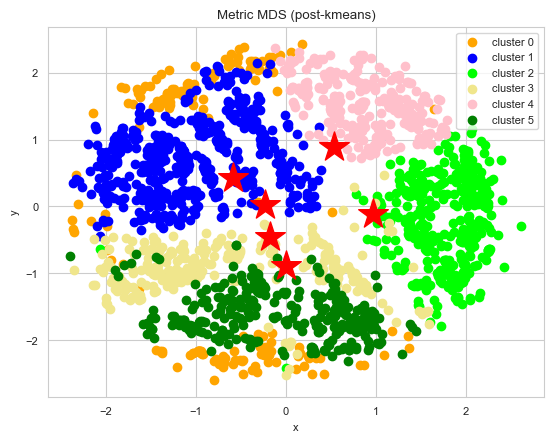

In [46]:
clustering_scatterplot_kmeans(points=XYcoordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='Metric MDS (post-kmeans)')

We can see some clear groupings but I also see lots of overlap at the boundaries and the centres are relatively close to each other. The MDS plot is a little 'muddled' at the boundaries but identifies two main sets of clusters (`{1,2,4}` and `{0,3,5}`; with lots of overlap between some clusters). 

### Non-Metric MDS

transformation complete


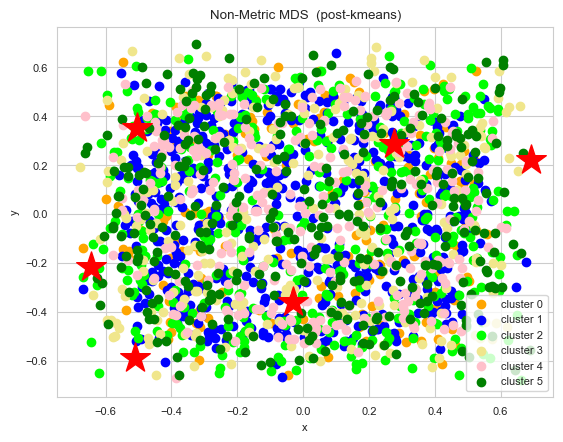

In [47]:
XYcoordinates = MDS(n_components=2, max_iter=5000, metric=False, normalized_stress='auto').fit_transform(data_and_centers)
print("transformation complete")

clustering_scatterplot_kmeans(points=XYcoordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='Non-Metric MDS  (post-kmeans)')

Visually, Non-metric MDS appears useless for this processed data set. There is no visible structure to speak of so I will stick with metric MDS from now on.

#### MDS Clustering Analysis Conclusion

Multi-Dimensional Scaling (MDS) is a technique used to visualise the structure of distances or dissimilarities in a dataset. Firstly, non-metric MDS appears unsuitable for this dataset (largely overlapping clusters, meaningless centroids etc...). So, here we will consider a Metric MDS only. The metric MDS plots indicates the existence of several clusters, differentiated by color. 

- **Centroids:** The red stars represent the centroids of each cluster, which are the mean position of all the points in each cluster. The centroids appear to gravitate towards each other.
- **Cluster Deifnition:** These clusters appear to be of similar size and well delineated, which suggests that the kMeans algorithm has found some delineation between the clusters. 
- **Overlap:** We do have some overlap around the borders.

### Apply t-SNE to project both the data and the k-Means cluster centers to a 2D space
[This](https://distill.pub/2016/misread-tsne/) article was especially helpful in understanding t-SNE. The idea behind t-SNE is to take an n-dimensional data set and map it to a lower dimension (in our case 2d), while maintaining a useful sense of the structure in that data set. The best example I have seen for this is comparing the use of PCA and t-SNE on the MNIST data set. t-SNE manages to capture distinct locations for each digit where PCA is less useful.

Here I will:

- Project both the data and the k-Means cluster centers to 2D, using t-SNE. 
- Plot the transformed examples and the centers. Use the cluster assignment to colour the examples so we observe the structure.
- I pay close attention to perplexity. The idea behind perplexity being to control how much effort is spent on identifying the global/local detail. In the appendix, I experiment with perplexity values to see the imapct. I eventually settle on a value of 40.
- I used a long iteration to enable the clusters to coalesce to a more meaningful state. If you set it to 250, the minimum, you do not get as good a seperation. So, I set it to 5000 (i.e. give it 'time to breathe').

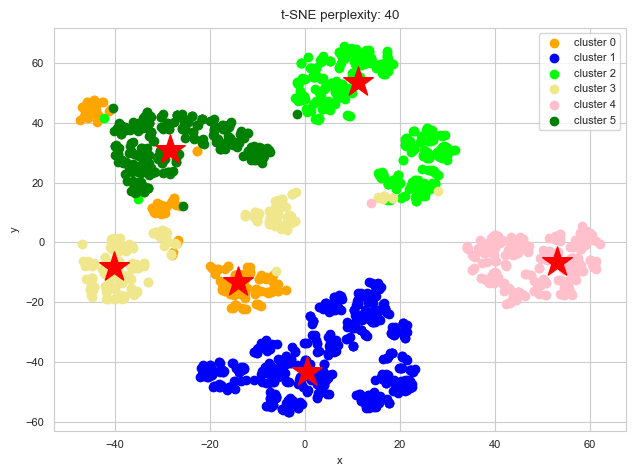

In [48]:
perplexity = 40 # see appendix for how I picked this -
n_clusters = len(np.unique(clustering_model['kMeans'].labels_))

tsne = TSNE(n_components=2, perplexity=40, n_iter=5000, init='random')
XYcoordinates = tsne.fit_transform(data_and_centers)

centers = XYcoordinates[-n_clusters:, :]  # Assuming the last n_clusters points are centers

clustering_scatterplot_kmeans(points=XYcoordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title=f't-SNE perplexity: {perplexity}')
plt.tight_layout()
plt.show()

This is pretty subjective, but it seems that a `perplexity` of 40-50 shows larger, more separated clusters - showing some global structure in the dataset. 

#### t-SNE Clustering Analysis Conclusion
t-SNE is far more adept at capturing the local structure of high-dimensional data and revealing clusters at several scales - the perplexity parameter controls this balance (our data is already preprocessed so different scales should not be a relevant factor).

> The key idea is to ﬁnd a 2-dim representation of the data that preserves the distances between points as best as possible.
Giussani, Andrea. Applied Machine Learning with Python, EGEA Spa - Bocconi University Press, 2020. ProQuest Ebook Central, http://ebookcentral.proquest.com/lib/univlime-ebooks/detail.action?docID=6110795.
Created from univlime-ebooks on 2024-04-17 11:50:38.

- The t-Distributed Stochastic Neighbour Embedding (t-SNE) plot identifies two main sets of clusters (`{1,2,4}`  and `{0,3,5}` ). You can easily split these two sets in the diagram.
- A **perplexity** of between 40-50 reveals the most structure.
- **Centroids:** The centroids, marked by red stars, indicate the average position of all points within each cluster. In the t-SNE plot, these centroids are placed within the bounds of their respective clusters and, in this case, are actually quite far apart - this is good as it helps to discern differences due to internal structure.

### Comparing MDS to t-SNE

Comparing the plots of Metric Multidimensional Scaling (MDS) and t-Distributed Stochastic Neighbour Embedding (t-SNE) in terms of:

1. **Cluster Separation**: t-SNE appears to provide a clearer separation between clusters. The clusters in the t-SNE plot are more distinct, whereas the MDS plot shows a nonlinear boundary with some overlap between the clusters.

2. **Data Distribution**: The t-SNE plot has a more complex structure with more visible gaps between data concentrations. This suggests that t-SNE might be capturing more of the local structure within the data. The t-Distributed Stochastic Neighbour Embedding (t-SNE) plot identifies two main sets of clusters (`{1,2,4}` and `{0,3,5}`). On the other hand, the MDS plot shows a more uniform distribution of points without clear sub-structures (six blobs gathered into one large circular cluster). The MDS plot also identifies two main sets of clusters (`{1,2,4}`  and `{0,3,5}`  with lots of overlap between clusters).

3. **Cluster Centres**: In both plots, the cluster centres (indicated by stars) are centrally located within their respective clusters. However, the centres of Clusters `{0, 3, 5}` and `{1,2,4}` in the t-SNE plot are more distant from from each other than in the MDS plot, indicating a more pronounced distinction as captured by t-SNE. That is, if distance to centre was a metric, then t-SNE clearly highlights the differences that MDS does not.

4. **Global vs. Local Relationships**: MDS tries to preserve the global pairwise distances between points, which might explain why the clusters appear closer together. In contrast, t-SNE (with the right perplexity and iteration values) focuses on preserving local relationships, often resulting in a map that reveals clusters within the data (you see structure at different scales).

These observations suggest that t-SNE (with proper data conditioning and t-SNE parameters) is far better at revealing the overall and underlying structure in this multi-feature dataset when compared to MDS.

# Task 3: DBSCAN
In your notebook e-tivity2.ipynb:

- Apply the DBSCAN clustering algorithm to the prepared bank dataset.
- Use MDS and t-SNE for visualising the clustering. 
- Write a short conclusion about the characteristics of the clusters and compare the performance of DBSCAN to k-Means. (max 250 words in a markdown cell).

### Applying DBSCAN to the original dataset
The idea here is to apply DBSCAN instead of kmeans to the original data set (using the previously built preprocessing pipeline). See appendix where I show how I picked values for `eps` and `min_sample` (I also output a .gif showing the evolution of the clusters using both MDS and t-SNE). 

**Note:** Something to consider. I *may* need a modified preprocessing pipeline for DBSCAN. But I do not have time to investgate now.

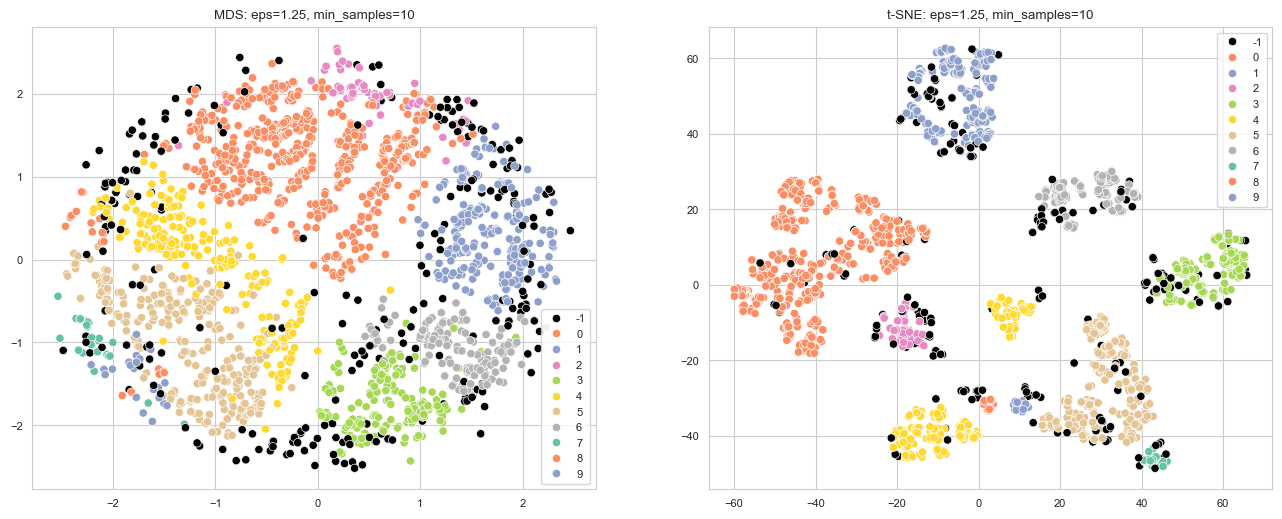

In [49]:
df = load_bank_data() #refresh df

eps = 1.25 
min_samples = 10 # see appendix to see how these were determined

pipe = Pipeline(steps=[
    ('preprocess', preprocessor_pipeline), 
    ('dbscan', DBSCAN(eps=eps, min_samples=min_samples)) 
    # forum shows video how I derived these https://learn.ul.ie/d2l/le/17939/discussions/threads/38192/View. 
])

clustering_model=pipe.fit(df)
transformed_data = pipe.named_steps['preprocess'].transform(df)
labels = pipe.named_steps['dbscan'].labels_

# Map each unique label to a color, ensuring noise (-1) is black
base_palette = sns.color_palette("Set2", 8) 
contrasting_colors = [color for color in base_palette if np.allclose(color, [1.0, 0.0, 0.0], atol=0.3) is False] 
unique_labels = np.unique(labels)
color_map = {label: ('black' if label == -1 else contrasting_colors[i % len(contrasting_colors)]) for i, label in enumerate(unique_labels) if label != -1}
color_map[-1] = 'black'  # Explicitly setting noise

palette = sns.color_palette([color_map[label] for label in unique_labels])

# Prepare the plotting space
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Run MDS
mds = MDS(n_components=2, random_state=5)
mds_transformed = mds.fit_transform(transformed_data)

sns.scatterplot(x=mds_transformed[:, 0], y=mds_transformed[:, 1], hue=labels, palette=palette, ax=axes[0])
axes[0].set_title(f'MDS: eps={eps}, min_samples={min_samples}')
axes[0].legend()

# Run t-SNE
tsne = TSNE(n_components=2, random_state=5, perplexity=40, n_iter=5000)
tsne_transformed = tsne.fit_transform(transformed_data)

sns.scatterplot(x=tsne_transformed[:, 0], y=tsne_transformed[:, 1], hue=labels, palette=palette, ax=axes[1])
axes[1].set_title(f't-SNE: eps={eps}, min_samples={min_samples}')
axes[1].legend()

This value of `eps` and `min_samples` has been tuned for this preprocessed dataset and has minimised the noise, leading to distinct clusters, especially visible in the t-SNE plot. t-SNE remains the better reducer and yields far more distinct clusters.

### Comparing MDS to t-SNE

Comparing the plots of Metric Multidimensional Scaling (MDS) and t-Distributed Stochastic Neighbour Embedding (t-SNE) in terms of:

1. **Cluster Separation**: Again, t-SNE appears to provide a clearer separation between clusters. The clusters in the t-SNE plot are more distinct, whereas the MDS are far less distinct with some overlap between the clusters. MDS tends to clump close regions to gether whereas t-SNE pushes them apart, to expose some underyping structure.

2. **Data Distribution**: The t-SNE plot has a more complex structure with more visible gaps between data concentrations. Again, this suggests that t-SNE might be capturing more of the local structure within the data. On the other hand, the MDS plot shows a more uniform distribution of points without clear substructures (3, slightly overlapping blobs).

3. **Global vs. Local Relationships**: MDS tries to preserve the global pairwise distances between points, which might explain why the clusters appear closer together. In contrast, t-SNE (with the right perplexity value) focuses on preserving local relationships, often resulting in a map that reveals clusters within the data.

These observations suggest that t-SNE (with proper data conditioning and t-SNE parameters) is far better at revealing the underlying structure in this multi-feature dataset when compared to MDS.

### See how original dataframe maps to DBSCAN clusters

#### Add cluster id back to original datasets
Now I add the cluster member to the dataframe so I can inspect how it correlates with the target variable, subscribed.

In [50]:
df['cluster_dbscan'] = pd.Series(clustering_model['dbscan'].labels_, index=df.index)
df['cluster_dbscan'] = df['cluster_dbscan'].astype('int')

In [51]:
df.head(5)

age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  \
0  cellular    1   apr       957         2    131         2  failure   
1  cellular    1   apr       233         2    133         1  failure   
2  cellular    1   apr       126         2    239         1  failure   
3  cellular    1   apr       274         1    238         2  failure   
4  cellular    1   apr       479         1    307         1  failure   

  subscribed  cluster_dbscan  
0         no               1  
1         no               0  
2         no               0  
3         no               0  
4         no               0

In [52]:
df.tail(5)

age           job  marital  education default  balance housing loan  \
1995  20.0       student   single        NaN      no     2785      no   no   
1996  28.0        admin.   single  secondary      no      127      no   no   
1997  81.0       retired  married    primary      no     1154      no   no   
1998  46.0      services  married    primary      no     4343     yes   no   
1999  40.0  entrepreneur  married  secondary      no     6403      no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \
1995   cellular   16   sep       327         2     -1         0      NaN   
1996   cellular   16   sep      1334         2     -1         0      NaN   
1997  telephone   17   sep       231         1     -1         0      NaN   
1998        NaN   20   sep       185         1     -1         0      NaN   
1999   cellular   22   sep       208         2     -1         0      NaN   

     subscribed  cluster_dbscan  
1995        yes               5  
1996        yes               5  
1997        yes               9  
1998        yes              -1  
1999        yes               5

### Cluster Review
I now have cluster assignments and can start to reason about how they are grouped using DBSCAN.

#### Review Summary Numeric Statistics Grouped by Cluster Id

In [53]:
summary_numeric_per_cluster = df.groupby('cluster_dbscan').mean(numeric_only=True)

summary_numeric_per_cluster.describe()

age      balance        day    duration   campaign       pdays  \
count  11.000000    11.000000  11.000000   11.000000  11.000000   11.000000   
mean   46.808844  1646.779991  13.608807  307.383055   1.910809  141.500420   
std    12.830960   894.805887   2.265879   76.181346   0.188876   85.489777   
min    37.331395   426.750000   7.781250  201.885714   1.526316   -1.000000   
25%    38.688475  1086.989919  13.299017  232.306588   1.793347   63.563321   
50%    41.750000  1605.679012  14.590909  324.337838   1.918969  160.385135   
75%    45.215777  1864.279580  14.661277  349.495085   2.018571  203.621552   
max    72.363636  3733.090909  15.578947  422.842105   2.185714  242.685714   

        previous  
count  11.000000  
mean    2.364103  
std     1.262461  
min     0.000000  
25%     1.411850  
50%     2.843462  
75%     3.148217  
max     3.837838

#### Review Summary Categorical Statistics Grouped by Cluster Id

In [54]:
summary = summarise_categoricals(df, 'cluster_dbscan')
summary.head(len(labels))

job Unique Values  \
cluster_dbscan                                                      
-1              {services, management, housemaid, self-employe...   
 0              {services, management, housemaid, self-employe...   
 1              {services, management, housemaid, self-employe...   
 2              {services, management, housemaid, admin., reti...   
 3              {management, housemaid, self-employed, admin.,...   
 4              {services, management, housemaid, admin., reti...   
 5              {services, management, housemaid, self-employe...   
 6              {management, housemaid, self-employed, admin.,...   
 7              {services, management, admin., technician, ent...   
 8                                                      {retired}   
 9                                                      {retired}   

               job Most Common  job Unique Count        marital Unique Values  \
cluster_dbscan                                                                  
-1                 blue-collar                11  {married, divorced, single}   
 0                  technician                11  {married, single, divorced}   
 1                  management                 9  {divorced, married, single}   
 2                 blue-collar                 7  {married, divorced, single}   
 3                  management                 7  {married, divorced, single}   
 4                      admin.                10  {married, single, divorced}   
 5                      admin.                11  {married, divorced, single}   
 6                  management                 7  {married, divorced, single}   
 7                 blue-collar                 6          {married, divorced}   
 8                     retired                 1          {married, divorced}   
 9                     retired                 1          {married, divorced}   

               marital Most Common  marital Unique Count  \
cluster_dbscan                                             
-1                         married                     3   
 0                         married                     3   
 1                         married                     3   
 2                         married                     3   
 3                          single                     3   
 4                         married                     3   
 5                         married                     3   
 6                          single                     3   
 7                         married                     2   
 8                         married                     2   
 9                         married                     2   

                       education Unique Values education Most Common  \
cluster_dbscan                                                         
-1              {primary, tertiary, secondary}              tertiary   
 0                                 {secondary}             secondary   
 1                                  {tertiary}              tertiary   
 2                                   {primary}               primary   
 3                                  {tertiary}              tertiary   
 4                                 {secondary}             secondary   
 5                                 {secondary}             secondary   
 6                                  {tertiary}              tertiary   
 7                                   {primary}               primary   
 8                                   {primary}               primary   
 9                                   {primary}               primary   

                education Unique Count default Unique Values  \
cluster_dbscan                                                 
-1                                   3             {no, yes}   
 0                                   1             {no, yes}   
 1                                   1             {no, yes}   
 2                                   1                  {n

As with kMeans previously. Some observed takeaways from the previous two tables:

#### Summary Categorical Statistics Grouped by Cluster Id:
We can see, from looking at the categorical tables, that clusters \{ 3,4,5,6,8,9 \} map to the `subscribed=yes` value and that clusters \{ 0, 1, 2, 7 \} map to the `subscribed=no` values. 

With this in mind, for all clusters:

 - The mode of contact does not seem to matter; most common one was `cellular`.
 - The most common loan state for all clusters is `no loan`.

##### **Clusters \{ 3,4,5,6,8,9 \}** tended to map to respondants who **subscribed**. 
For those clusters:

- Most common `month` was in `May, Aug, Sept, July`, 
- Most common `poutcome` was `other` or `success`. 
- Most common `job`s were `management, retired, admin, technician`

##### **Clusters \{ 0, 1, 2, 7 \}** tended to map to respondants who **did not subscribe**.
For those clusters:

- Having a `housing` loan was quite a common trait for non-subscribers
- Most common `poutcome` in 3 sub-clusters was `failure`. 1 sub-cluster had a common `poutcome` of `other` (perhaps this was for people who were contacted for the first time). Suggests previous tendency to subscribe impacts the chance of re-subscribing. 
- Most common `month` was in \{ feb, may \}. `May` appears to be an anomaly here but perhaps it's still too early in the year to contact some customers (i.e. most common job in this cluster `married`, `blue-collar` workers?
- Most common `job`s were `Management, Technician, blue-collar` - so perhaps blue-collar is the standout here and `retired` is the standout for the clusters who did tend to subscribe.

#### Summary Numeric Statistics Grouped by Cluster Id  
As with kMeans:

- `Balance`, `pdays` and `duration` tend to have the biggest skews
- No obvious or significant patterns noticed between the various clusters and these numerical variables.

**Overall, the cluster relationship reveals underlying structure in the data. The key takeaway is that, for this processed data set, the subscribed state *appears* to mostly rely on values within a subset of the categorical variables (e.g. subscription depends on Month last contacted, previous outcome, job and not having a housing loan).**

# Summary

Here is a brief synopsys of how I believe I have met the requirements of the rubric linked [here](https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=17939&rubricId=1707&originTool=quicklinks).

## Data preparation pipeline

I created a comprehensive data preparation pipeline that accounted for missing values, scale and skew. This required creating some custom transformers, with support for feature name return so output dataframes could retain naming (this makes it easier to reason about columns after you have processed them; without this you end up looking at column headers with numbers ranging from 0-n). 

* **age**  I used a simple imputer with a median strategy (as we had very minor skew and outliers and we don't have a significant number of missing age entries). Re-scaled using a min/max scaler.
* **job** Used a simple imputer that filled missing entries with unknown  (we don't have a significant number of missing job entries). 
* **marital** Same approach as job, for the same reasons.
* **education** Modified an existing kNN imputer based on the mode (this was done as a significant number of education entries were missing).
* **default** Same approach as job, for the same reasons.
* **balance** This is by far the attribute with the greatest range and outliers. I used a median imputer here, clipped outliers based on IQR_1.5, applied a power transform due to the strong right skew and finally rescaled with a min/max scaler.
* **housing** Same approach as job, for the same reasons.
* **loan** Same approach as job, for the same reasons.
* **contact** Same approach as job, for the same reasons.
* **day** Same as age, for the same reasons.
* **month** Tested for missing data. Applied a custom cyclic feature transformer, followed by min/max scaler.
* **duration** Same as balance (strongly right skewed data).
* **campaign** Same as age, for the same reasons.
* **pdays** Same as balance, for the same reasons.
* **previous** Same as age, for the same reasons.
* **poutcome** Created a custom imputer that used the pdays column to fill-in missing poutcome entries (i.e. if pdays == -1, then putcome = other). Used a one-hot encoder.

At the end of this, the preprocessed data all existed within the range $[0,1]$.  

## kMeans clustering
kMeans is known as a centroid-based clustering algorithm, partitioning the space into k clusters; the number of clusters is specified by the user. I used the *Elbow* method and *Silhouette* Anlaysis to determine an ideal number of clusters. Both yielded strong k-values at $k=6$ for the preprocessed data set (I also saw potential k values at 3 and 12). It is worth stating that the behaviour of kMeans and DBSCAN is heavily influenced by almost every aspect of the pipeline (e.g. scaling or lack thereof, not tackling skew or outliers, mishandling imputation - each adjustment can cause a radical shift in the clustering output and required lots of iteration). It is worth mentioning that the silhouette approach also yielded another relatively strong k-value at $k=12$. You could argue that there was also a weaker k-value at $k=3$. What's notable here is the relationship between $[3,6,12]$. In fact, looking at the eventual clusters that I got, we likely have 3 main clusters - and these sub-clusters give a little more information on the structure of the system. 

After kMeans, I was able to group the numerical and categorical values by their cluster id. The led me to the realisation that, overall, the relationship between the cluster and the subscribed state *appears* to rely on the categorical variables far more than the the numerical variables.

## DBSCAN clustering
Unlike kMeans, DBSCAN is a density-based clustering algorithm where the clusters 'coalesce' around core values, based on distance to each other. So, again, the scale of the input features matter. I implemented DBSCAN for various values of eps and min_samples, ultimately setting on a final value that gives a good score. To do this, I used a home-brew parameter search to find suitable values of eps and min_value - explained in the appendix. I found that, as expected, the values of eps, in particular, were closely linked to the scale of the data, if the values of eps were too low or too high I tended to get a single cluster or mostly noise/anomalous results.	 

## Comparing kMeans to DBSCAN
**kMeans** partitions the data into a predefined number of clusters, $k$, specified by the user. We start with random centroids and assigns each data point to the nearest centroid. The centroids are then recalculated based on the assignments, and this process repeats until the centroids stabilise. K-means works best with spherical cluster shapes and similar cluster sizes.

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** defines clusters as regions of high density separated by regions of low density. It does not require the number of clusters to be specified in advance. DBSCAN groups together closely packed points and marks points in low-density regions as noise or outliers.

Both methods require the user to set parameters. The output is also very sensitive to the type of data you input (i.e. scale of the data). **kMeans** is highly sensitive to the choice of $k$ (the number of clusters), which needs to be specified before running the algorithm. It is also sensitive to the initial placement of centroids. **DBSCAN** is sensitive to two parameters: `eps` (the maximum distance between two samples for them to be considered as in the same neighborhood) and `min_samples` (the minimum number of points required to form a dense region). Proper tuning of these parameters is crucial for good clustering performance.

**kMeans** does not do well with noise as every point gets assigned to a cluster regardless of how far it is from its centroid. **DBSCAN** is far better at handling noise and outliers as it can identify and treat noise points that do not belong to any cluster.

**kMeans** assumes that clusters have a similar size and variance, fitting circular or spherical clusters. **DBSCAN**, on the other hand, can find arbitrarily shaped clusters and is good for datasets where clusters are irregularly shaped and potentially interspersed (it clusters close points and pushes away the disimilar points).

Both have their strengths and weakness. But, in this etivity, the net result of analysing the mapping between the cluster IDs and the subscribed state was the same for DBSCAN as for kMeans. When examining the data visually using t-SNE for dimension reduction, as well as considering the relationship between the cluster and the subscribed state, it seems that a subset of categorical variables significantly influences the outcomes more than numerical variables. Additionally, I found that visualising the manifold learned by MDS was less useful as the data tended to 'clump' together (creating lots of overlaps between sub-clusters). Overall, t-SNE appears to be better at determining local and global structure (pushing different clusters apart and pulling similar ones together).

## Quality of visualisation of the clusters

I used both MDS and t-SNE reduction on the clustering output. Metric MDS tended to reveal a single "clump" of clusters, with centroids that were close together and blurred boundaries between those clusters. While t-SNE tended to 'push' the clusters apart in a way that tended to reveal far more structure (I had posted on the forum about trying this on the MNIST data and was quite surprised at how it compared to PCA - each cluster mapped to a digit). 

Overall, t-SNE provided far clearer visualisations for both kMeans and DBSCAN. And, for kMeans, these visualisations suggested that the 6 and 12 clusters I had identified earlier were actually subclusters for 3 major clusters. 

# References
- [Visualizing Data using t-SNE by Maaten and Hinten](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)
- [Misreading t-SNE](https://distill.pub/2016/misread-tsne/)
- [Principal manifolds and nonlinear dimensionality reduction via tangent space alignment](https://arxiv.org/abs/cs/0212008)

## Acknowledgements

- Inspiration on neater ways to use the columnTransformer from RuiAlexandre FaustinoDe
- Some plotting advice from RuiAlexandre FaustinoDe
- DBSCAN docs shared by Pierce Currid
- kNN Imputation suggetsions from e-tivity1

# Appendix

## Silhouette Diagrams

The following code is taken from [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html). It was modified to support the actual data set I have.

For n_clusters = 2 The average silhouette_score is : 0.1274427119401005
For n_clusters = 3 The average silhouette_score is : 0.1384864577051379
For n_clusters = 4 The average silhouette_score is : 0.14767533900991703
For n_clusters = 5 The average silhouette_score is : 0.11408832811588453
For n_clusters = 6 The average silhouette_score is : 0.144409348128234
For n_clusters = 7 The average silhouette_score is : 0.15178065601333426
For n_clusters = 8 The average silhouette_score is : 0.14542411849962014
For n_clusters = 9 The average silhouette_score is : 0.15990445792700483


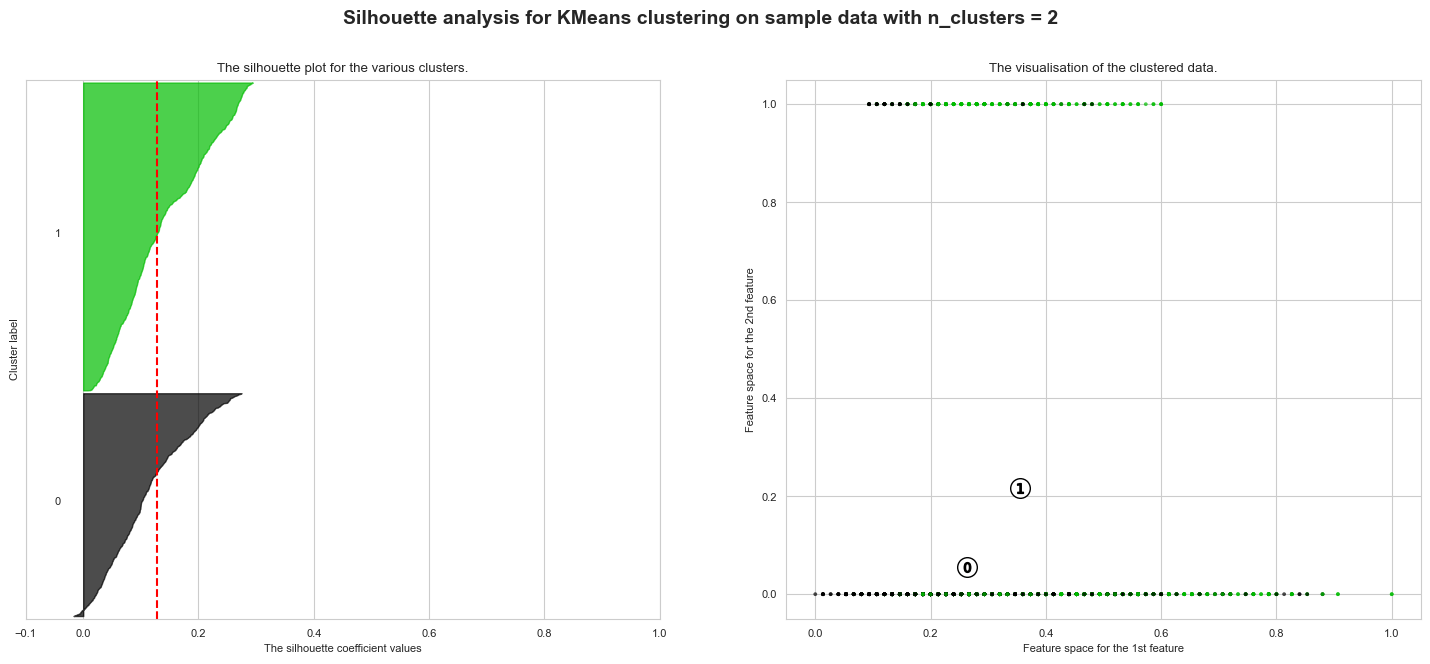

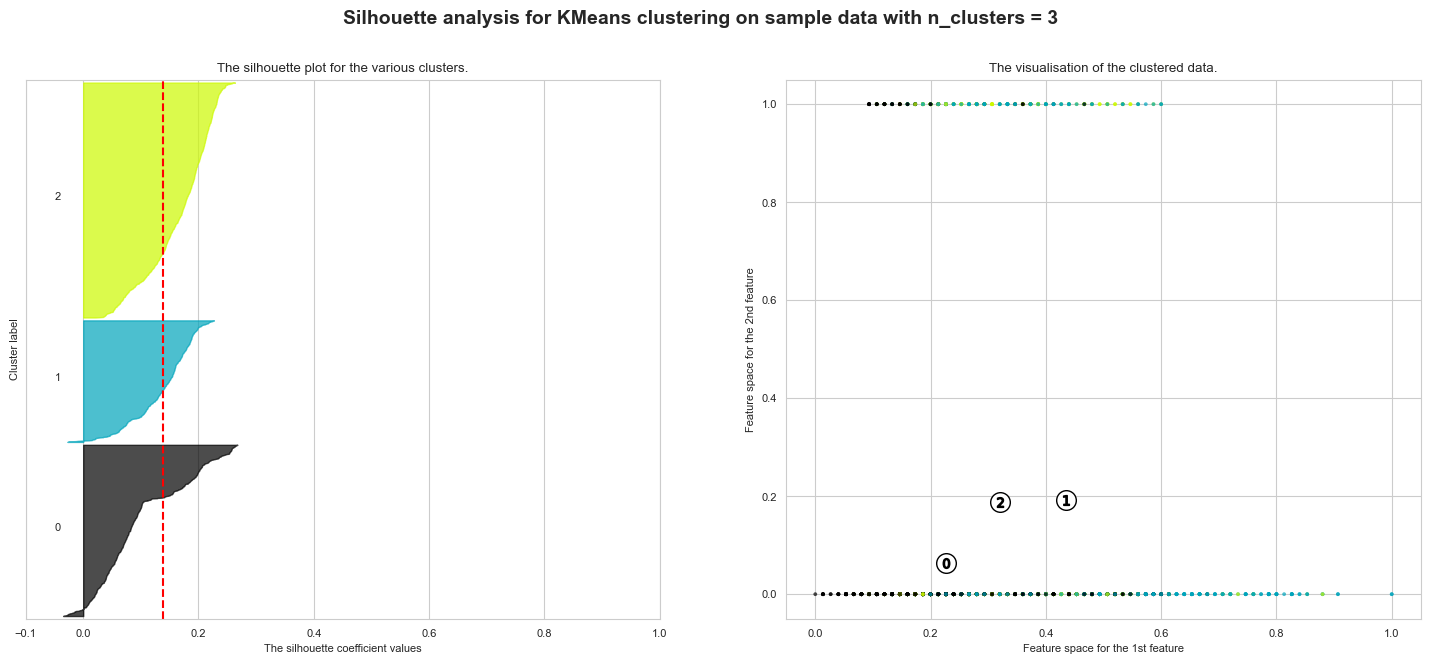

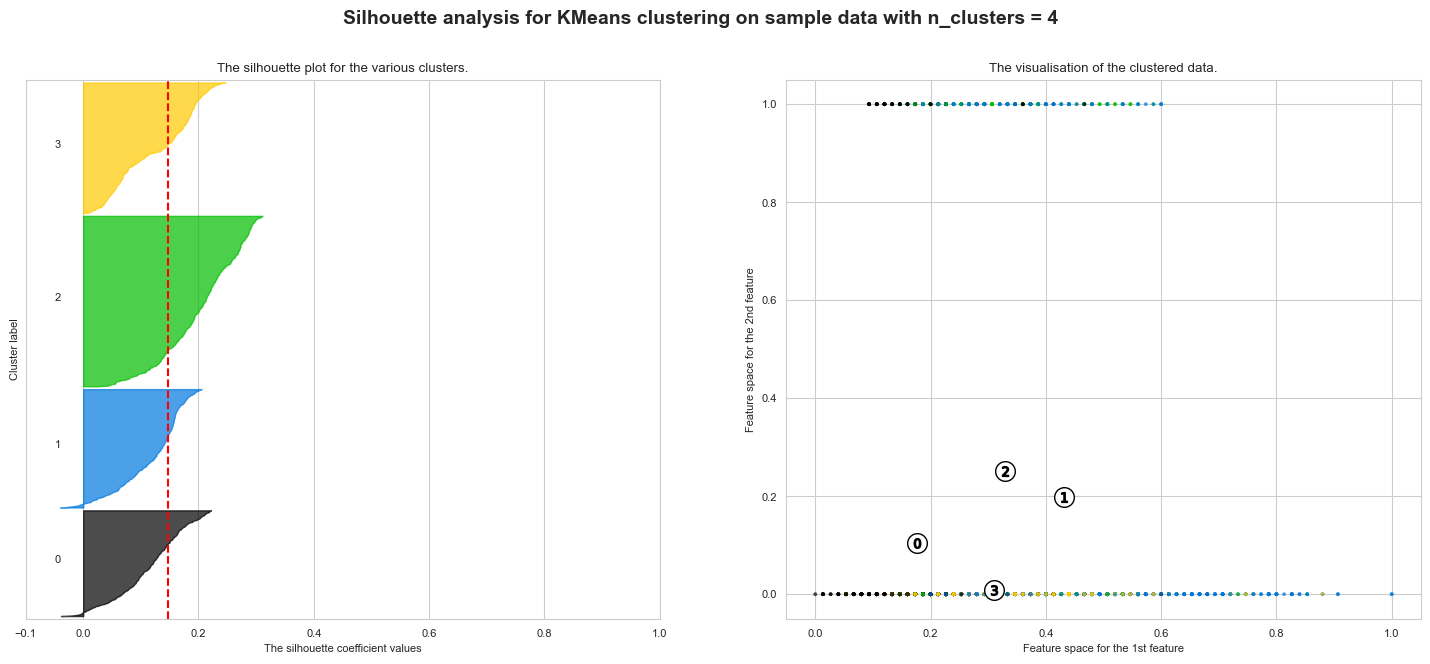

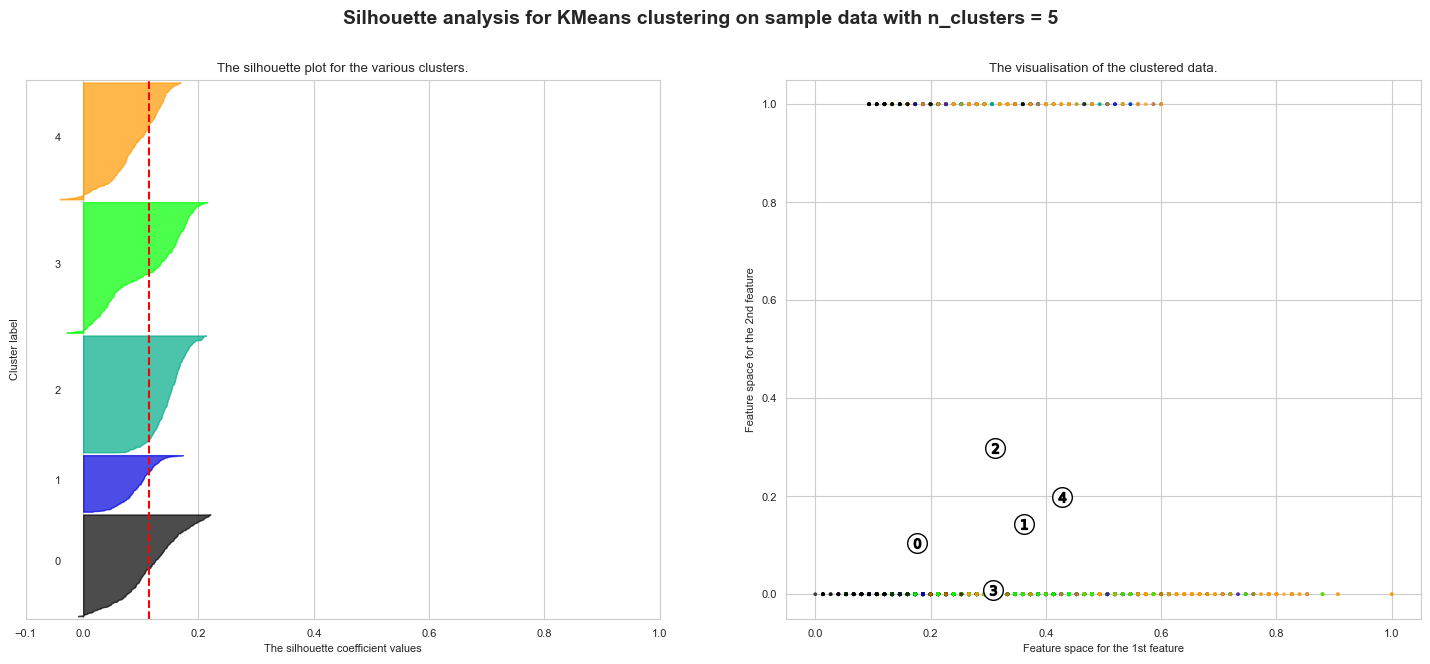

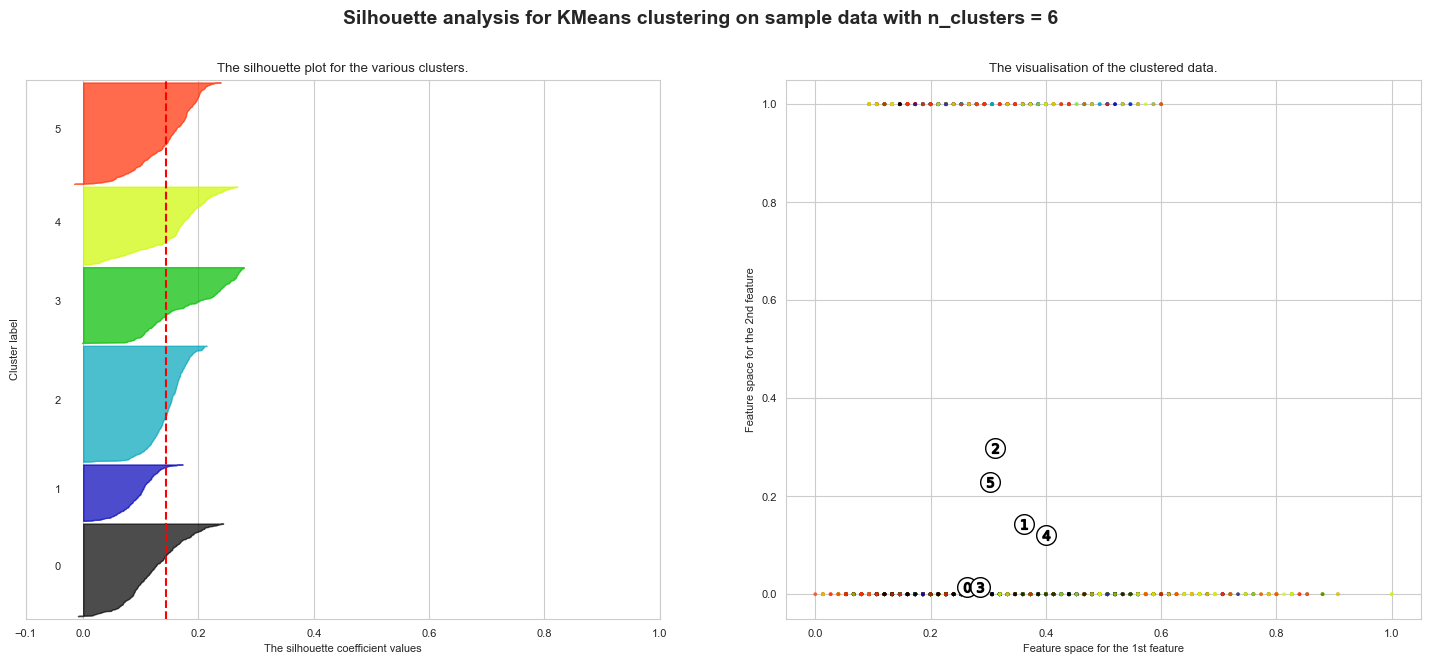

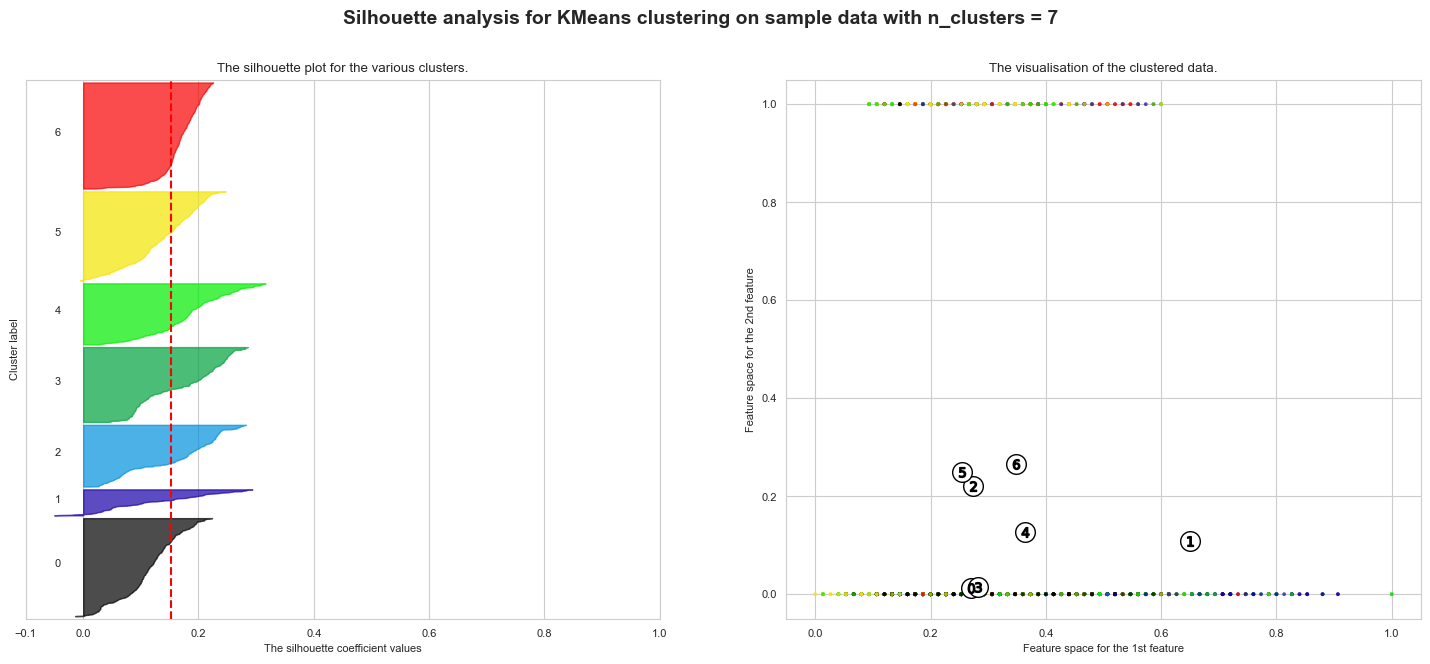

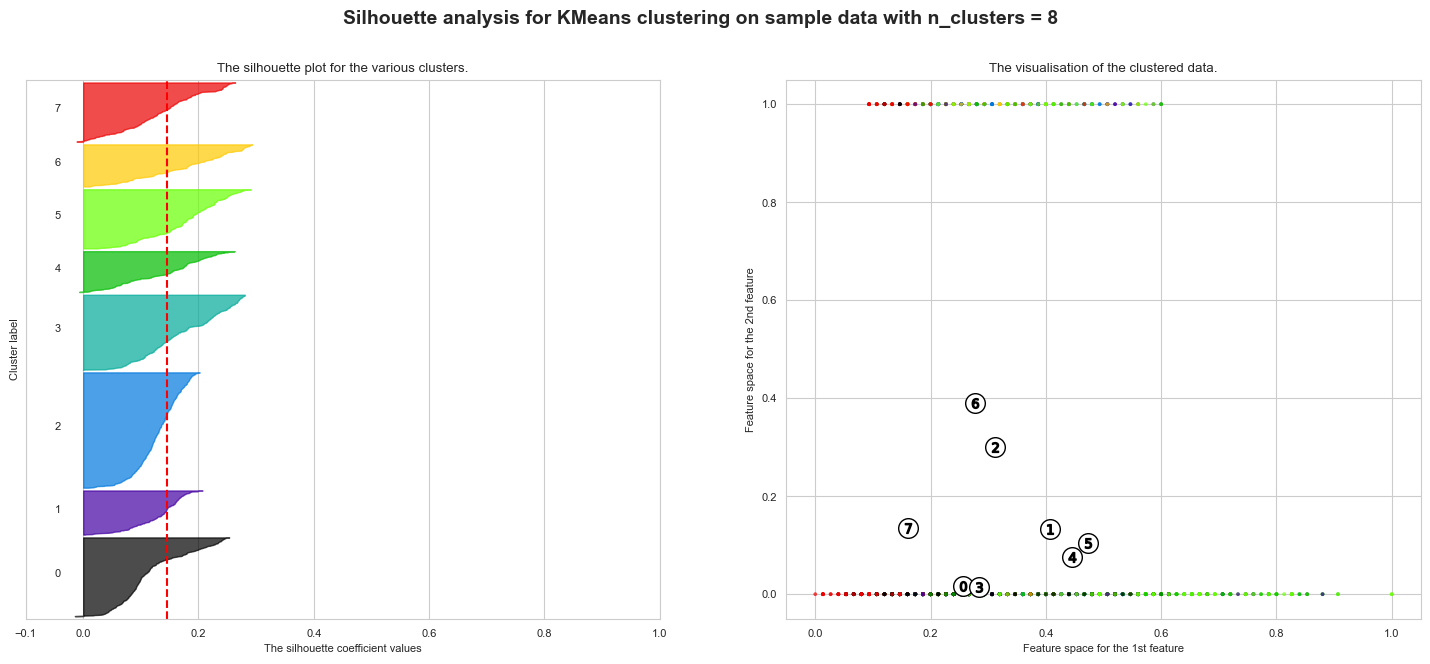

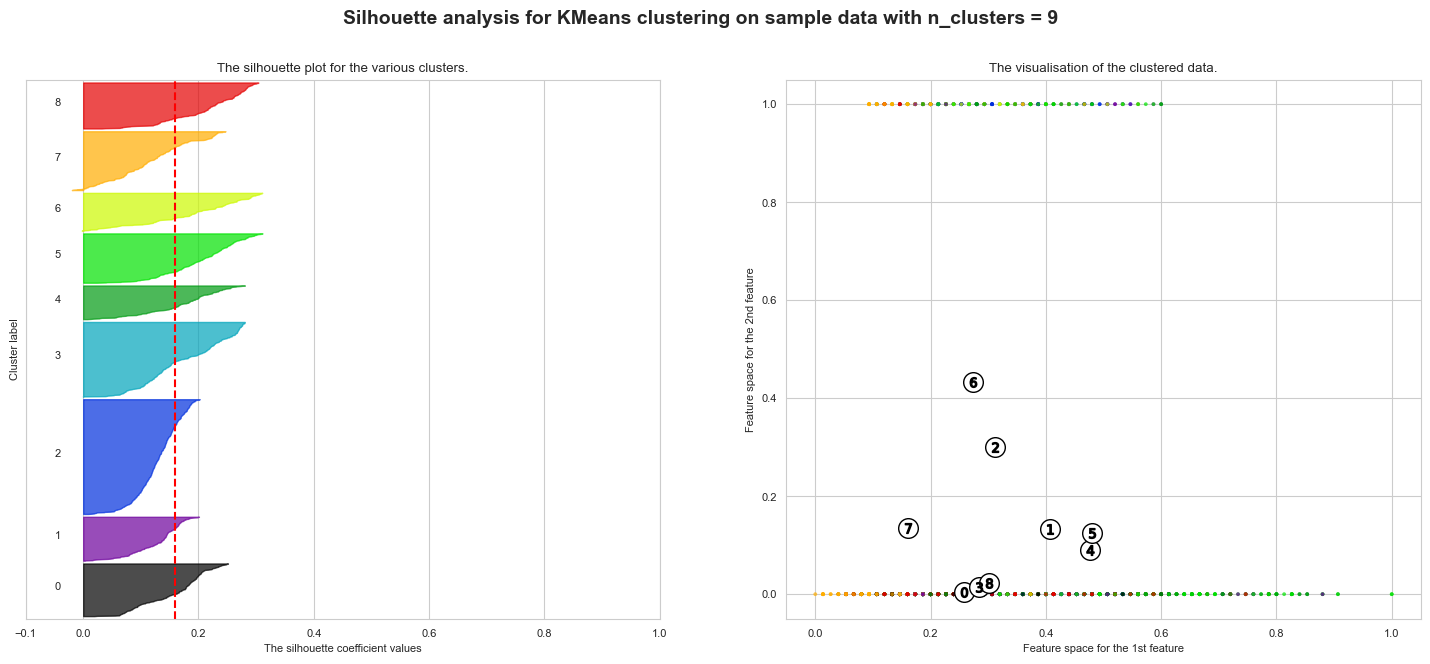

In [55]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

X = df_preprocessed.values

range_n_clusters = range(2, 10)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialise the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualisation of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

The encouraging thing about the shape (and areas) of the 'blades' on the above diagram suggest that we have good pre-processing (scaling, skew management etc...). And, I suspect that many of the clusters are actually sub-clusters.

## Try out SVM with new pipeline
I understand that this is not part of work but I wanted to see how the ML pipeline might work, end-to-end.

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_curve, auc, RocCurveDisplay

df = load_bank_data()

label_encoder = LabelEncoder() # Convert 'subscribed' into numeric labels if it's not already
df['subscribed'] = label_encoder.fit_transform(df['subscribed'])

y = df['subscribed']  # Target vector

X = df.copy()
X = df.drop('subscribed', axis=1)  

X.head(5)

age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  
0  cellular    1   apr       957         2    131         2  failure  
1  cellular    1   apr       233         2    133         1  failure  
2  cellular    1   apr       126         2    239         1  failure  
3  cellular    1   apr       274         1    238         2  failure  
4  cellular    1   apr       479         1    307         1  failure

In [57]:
y.head(5)

0    0
1    0
2    0
3    0
4    0
Name: subscribed, dtype: int64

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       200
           1       0.96      0.95      0.95       200

    accuracy                           0.95       400
   macro avg       0.96      0.95      0.95       400
weighted avg       0.96      0.95      0.95       400



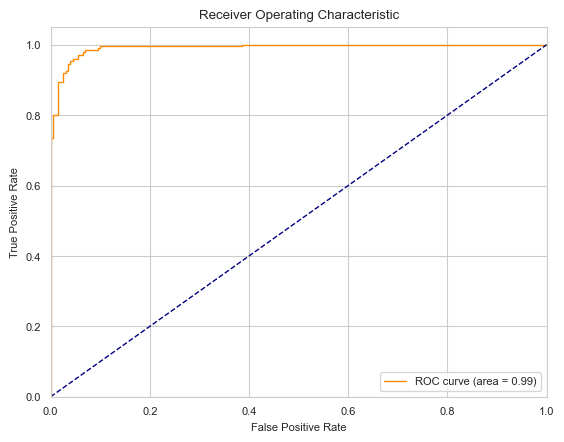

In [58]:
# Define the full pipeline, including the classifier
pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('svm', SVC(kernel='rbf', probability=True))
])

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5, stratify=y)

#fit
svm_model = pipe.fit(X_train, y_train)

#Evaluate
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]  # get the probability of the positive class
print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The key takeaway here is that, once you have a properly processed pipeline, it makes it easy to switch out where you are sending the data; e.g. kMeans, DBSCAN or SVM. This makes it easier to compartmentalise and test various aspects of the pipeline and gives a measure of comfort that all elements are working correctly. The alternative is a Jupyter notebook that is more adhoc and hence harder to reason about.

## Experimenting with t-SNE Perplexity

- Use range of perplexity values with t-SNE (see appendix).
- Focus on the plots that reveal the most structure (note the associated perplexity).

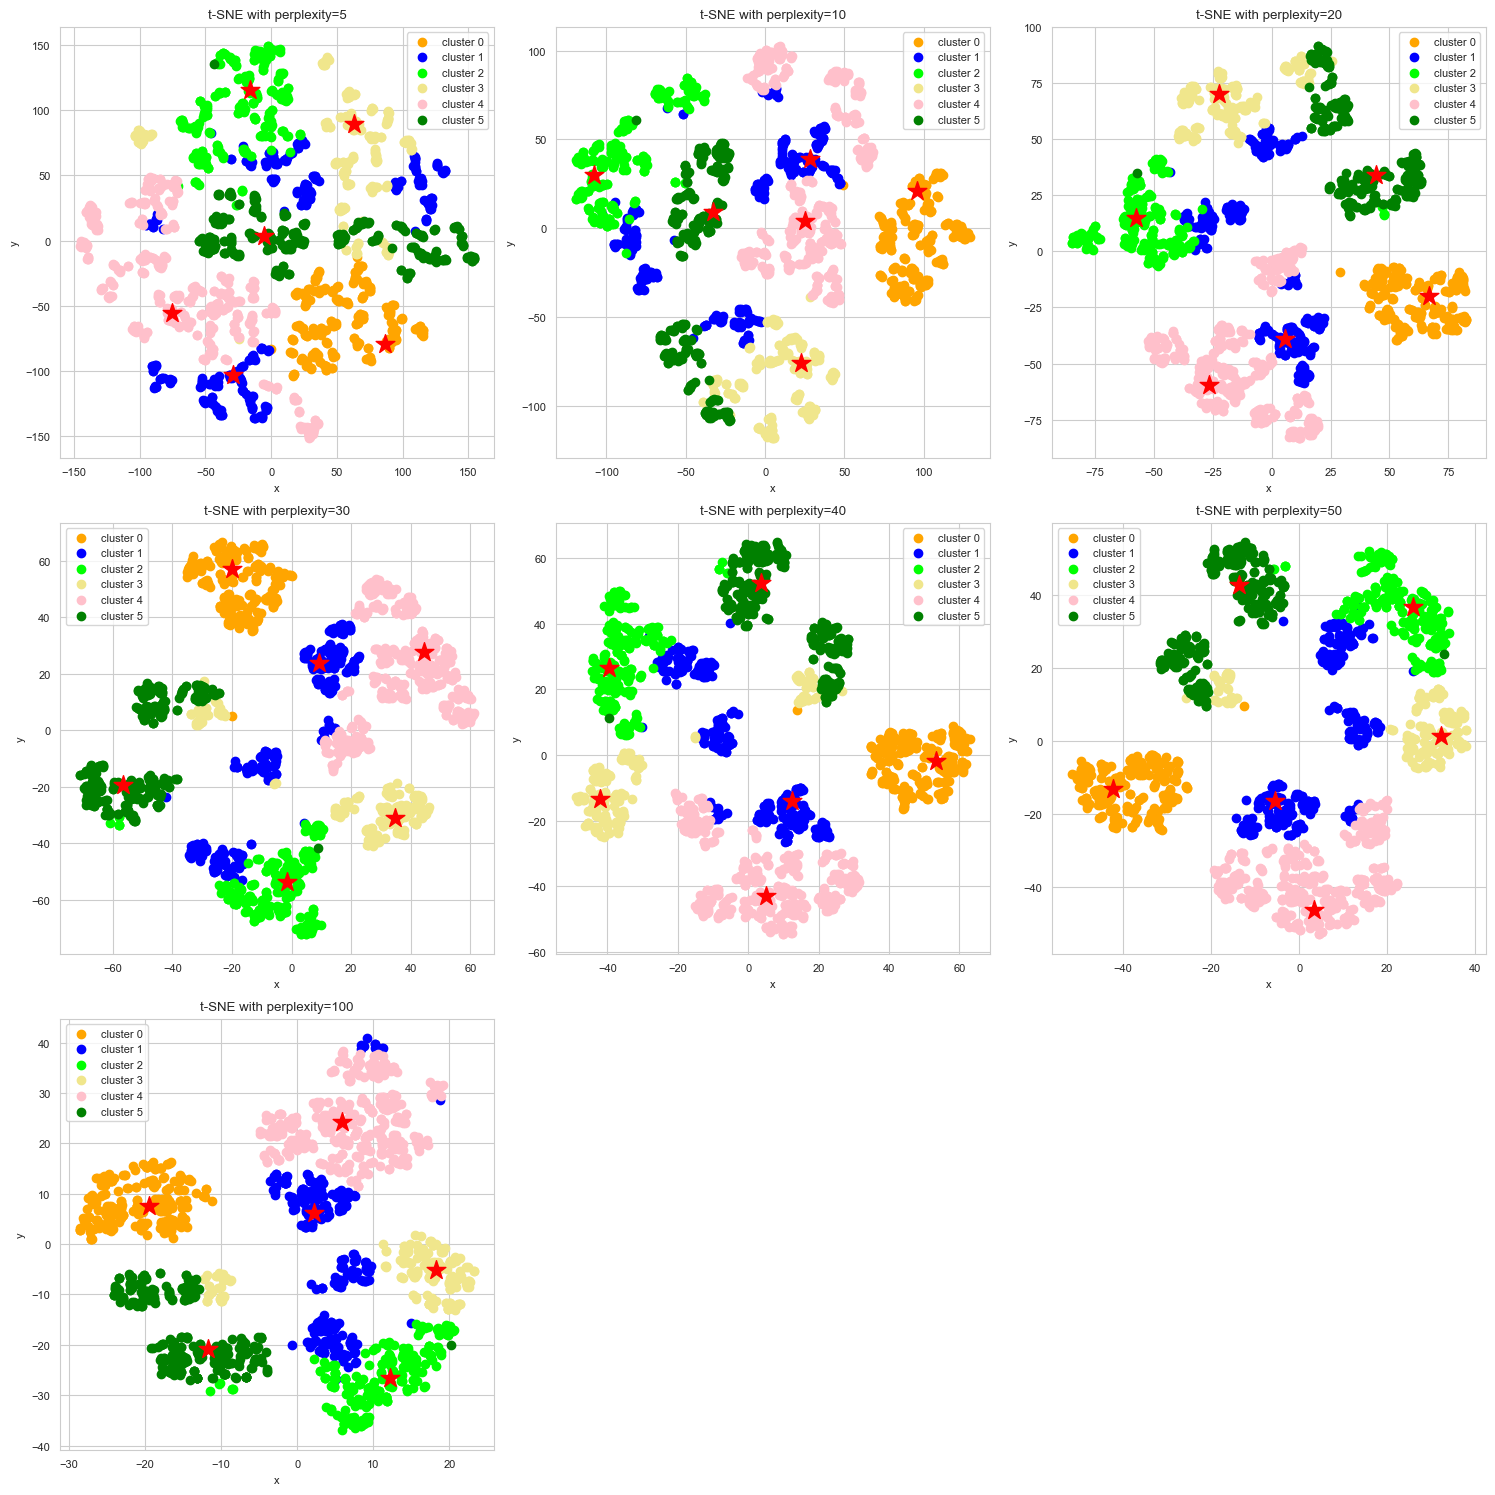

In [59]:
 # I want to know how perplexity impacts the reduction in dimensions
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple', 'red', 'yellow', 'gray', 'cyan', 'magenta'])

def clustering_scatterplot_mod(points, labels, centers, title, ax):
    """ 
        Rewrite of earlier function to allow grid of t-SNE plots with varying perplexities.
    """
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        ax.scatter(points[labels == i, 0], points[labels == i, 1], c=colors[i % colors.size], label='cluster ' + str(i))

    if centers is not None:
        ax.scatter(centers[:, 0], centers[:, 1], c='red', marker='*', s=200)  # Adjusted for better visibility

    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    if len(np.unique(labels)) <= 10:  # Show legend only if clusters are not too many
        ax.legend()

def plot_tsne_perplexities(data, labels, perplexities, n_iter=5000, cols=3):
    """
        PLot the t-SNE graph for a range of perplexities. Im looking for the
        plot that gives best global structure.
    """

    n_clusters = len(np.unique(labels))
    rows = (len(perplexities) + cols - 1) // cols  # Calculate the needed rows
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))  # Adjust the size based on number of plots

    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])  # Ensure axes is always an array even for a single subplot

    axes = axes.flatten()  # Flatten in case of multi-row
    for ax, perplexity in zip(axes, perplexities):
        tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, init='random')
        transformed_data = tsne.fit_transform(data)
        centers = transformed_data[-n_clusters:, :]  # Assuming the last n_clusters points are centers

        clustering_scatterplot_mod(points=transformed_data[:-n_clusters, :], labels=labels, centers=centers, title=f't-SNE with perplexity={perplexity}', ax=ax)

    # Hide unused axes if any
    for ax in axes[len(perplexities):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

df = load_bank_data() #refresh df

pipe = Pipeline(steps=[
    ('preprocess', preprocessor_pipeline), 
    ('kMeans', KMeans(n_clusters=best_k_value, n_init=10, max_iter=300))
])

clustering_model = pipe.fit(df)
data_and_centers = np.r_[preprocessed_data,clustering_model['kMeans'].cluster_centers_]

perplexities = [5, 10, 20, 30, 40, 50, 100]  
plot_tsne_perplexities(data_and_centers, clustering_model['kMeans'].labels_, perplexities)

## Finding the best eps and min_sample for DBSCAN

The goal here is to find the best combination of values for eps and min_sample. I do this by selecting a range of (what I think are) good values for eps and min_samples and then generate DBSCAN clusters for them. At each stage I perform and MDS and t-SNE dimension reduction and save the resulting plots to disk. Afterwards, these plots are saved into a .gif to aid understanding. I use the best silhouette score as an indicator of a good pair of values. 

The following cell will identify a good `eps` and `min_sample` and will also generate a .gif showing the evolution of clusters in DBSCAN.

In [60]:
df = load_bank_data()

pipe = Pipeline([
    ('preprocess', preprocessor_pipeline),
    ('dbscan', DBSCAN())
])

import os # remove

def find_best_params(X, eps_values, min_samples_values, output_folder="plots"):
    """
    Evaluate DBSCAN with different parameters and visualize using MDS and t-SNE.
    Ensures noise is consistently colored red and other clusters are contrasty.
    """
    best_score = -1
    best_params = {}

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Define a contrasting color palette - red will be noise
    base_palette = sns.color_palette("Set2", 8)  # Set2 has good contrast away from red
    contrasting_colors = [color for color in base_palette if np.allclose(color, [1.0, 0.0, 0.0], atol=0.3) is False]  # Exclude colors close to red

    for eps in eps_values:
        for min_samples in min_samples_values:
            pipe.set_params(dbscan__eps=eps, dbscan__min_samples=min_samples)
            pipe.fit(X)
            transformed_data = pipe.named_steps['preprocess'].transform(X)
            labels = pipe.named_steps['dbscan'].labels_

            # Map each unique label to a color, ensuring noise (-1) is red
            unique_labels = np.unique(labels)
            color_map = {label: ('red' if label == -1 else contrasting_colors[i % len(contrasting_colors)]) for i, label in enumerate(unique_labels) if label != -1}
            color_map[-1] = 'red'  # Explicitly setting noise to red
            palette = sns.color_palette([color_map[label] for label in unique_labels])

            # Plotting setup
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))

            # MDS
            mds = MDS(n_components=2, random_state=5)
            mds_transformed = mds.fit_transform(transformed_data)
            sns.scatterplot(x=mds_transformed[:, 0], y=mds_transformed[:, 1], hue=labels, palette=palette, ax=axes[0])
            axes[0].set_title(f'MDS: eps={eps}, min_samples={min_samples}')
            axes[0].legend()

            # t-SNE
            tsne = TSNE(n_components=2, random_state=5)
            tsne_transformed = tsne.fit_transform(transformed_data)
            sns.scatterplot(x=tsne_transformed[:, 0], y=tsne_transformed[:, 1], hue=labels, palette=palette, ax=axes[1])
            axes[1].set_title(f't-SNE: eps={eps}, min_samples={min_samples}')
            axes[1].legend()

            # Save the plot for later giffing
            plt.suptitle(f'DBSCAN Cluster (eps={eps} and min_samples={min_samples})')
            filename = f"{output_folder}/eps{eps}_min_samples{min_samples}.png"
            plt.savefig(filename)
            plt.close()

            # Calculate silhouette score if valid (excluding noise)
            if len(set(labels)) - (1 if -1 in labels else 0) > 1:
                score = silhouette_score(transformed_data, labels)
                if score > best_score:
                    best_score = score
                    best_params = {'eps': eps, 'min_samples': min_samples}
            else:
                print(f"No valid clusters found for eps={eps}, min_samples={min_samples}")

    return best_params, best_score

eps_values = np.arange(1, 2.0, 0.25) #close to the scale that our data is, post processing
min_samples_values = range(10, 50, 10)

best_params, best_score = find_best_params(df, eps_values, min_samples_values)
print(f"Best Params: {best_params}, Best Score: {best_score}")

import imageio
def create_gif(image_folder, gif_name, duration):
    """
    Create a GIF from a series of images in a folder.
    """
    images = []
    for filename in sorted(os.listdir(image_folder)):
        if filename.endswith('.png'):
            file_path = os.path.join(image_folder, filename)
            images.append(imageio.imread(file_path))
    imageio.mimsave(gif_name, images, fps=1)

# After running the parameter sweep
create_gif("plots", "dbscan_clustering_evolution.gif", duration=0.2)

No valid clusters found for eps=1.0, min_samples=40
No valid clusters found for eps=1.5, min_samples=10
No valid clusters found for eps=1.5, min_samples=20
No valid clusters found for eps=1.5, min_samples=30
No valid clusters found for eps=1.5, min_samples=40
No valid clusters found for eps=1.75, min_samples=10
No valid clusters found for eps=1.75, min_samples=20
No valid clusters found for eps=1.75, min_samples=30
No valid clusters found for eps=1.75, min_samples=40
Best Params: {'eps': 1.25, 'min_samples': 10}, Best Score: 0.13557886186190904


/var/folders/3k/7q973s3s0g9gskwz519m65q00000gn/T/ipykernel_58022/455750715.py:87: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


In [61]:
print('Completed!')

Completed!
